# N doped graphene and diamond

- [Multiplicity](#multiplicity)
- [Simple QUBO](#simple_qubo)
- [Build the structures](#structures)
    - [Graphene](#graphene_structure)
        - [Write structures](#write_graphene_structure)
    - [Diamond](#diamond_structure)    
- [Interaction energies](#interaction)
    - [Graphene](#graphene_energy)
    - [Diamond](#diamond_energy)
- [Build and the energy model](#energy_model)
    - [Binary](#binary)
        - [Chemical potential](#chemical_potential_binary)
    - [Discrete](#discrete)
        - [Chemical potential](#chemical_potential_discrete)
- [Compare DFT and QUBO enenergies](#QUBO_DFT_energy)

- [Run the anneal](#anneal)
    - [Run the anneal (binary)](#anneal_binary)
    - [Run the anneal (discrete)](#anneal_discrete)    
    - [Identify symmetry equivalent structures](#symm_eq_structures)
- [Test the parameters](#test)
- [New workflow](#workflow)
- [Diamond](#diamond)
- [DQM](#dqm)
- [Graphene geometry optimisation](#optgeom)
- [The descriptor](#descriptor)

In [3]:
from quantum_computing_functions import *
from quantum_computing_postprocessing import *

from dwave.embedding.chain_strength import  uniform_torque_compensation

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from pymatgen.ext.matproj import MPRester

from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
import sys
sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')
from crystal_io import *
from convert import *
import re
import shutil as sh

# from CRYSTALpytools.crystal_io import * 
# from CRYSTALpytools.convert import * 
# from crystal_functions.execute import *

import copy
from sklearn.metrics import mean_squared_error 

import dataframe_image as dfi
from dscribe.descriptors import CoulombMatrix

import itertools

In [2]:
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

# <a id='multiplicity'>Multiplicity</a>


Text(0, 0.5, 'n configurations')

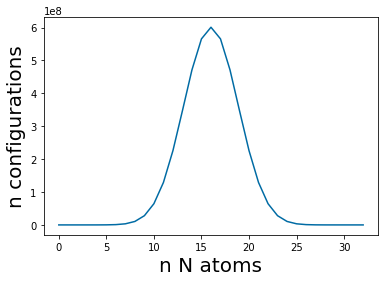

In [757]:
import math
binomial = []
def binomial_coefficient(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))
for i in range(33):
    binomial.append(binomial_coefficient(32, i))

plt.plot(np.arange(33),binomial) 

#plt.yscale('log')
plt.xlabel('n N atoms',fontsize=20)
plt.ylabel('n configurations',fontsize=20)

# <a id='structures'>Build the structures</a>


# <a id='graphene_structure'>Graphene</a>

#### pymatgen

In [4]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

#optimised cell
lattice = np.array([[  0.212090484210E+01, -0.122450498151E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.244900996303E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.000000000000E+00,  0.500000000000E+03]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 4
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_32 = copy.deepcopy(graphene)
graphene_32.make_supercell(scaling_matrix)
#structure = graphene_32

#number of atoms
N_C_g = graphene_32.num_sites
#number of bonds
N_CC_g = N_C_g*1.5

#### CRYSTALpytools

In [3]:
#graphene_32 = Crystal_gui().read_gui('./data/crystal/graphene/graphene_32.gui')

### All irreducible structures

In [6]:
def generate_symm_irr_structures(gui_object, output_object, new_atom):
    """
    Generate symmetrically-irreducible structures with atom substitutions.

    Args:
        gui_object: The GUI object.
        output_object: The output object.
        new_atom: The new atom to substitute.

    Returns:
        List of generated structures.
    """
    output_object.get_config_analysis(return_multiplicity=True)
    original_structure = cry_gui2pmg(gui_object)
    multiplicity = output_object.multiplicity
    structures = []

    for substitutions in output_object.atom_type2:
        new_structure = original_structure.copy()
        for i in substitutions:
            new_structure.replace(i - 1, new_atom)
        structures.append(new_structure)

    return structures, multiplicity



In [7]:
new_atom = 'N'
gui_object = Crystal_gui().read_gui('./data/crystal/graphene/config_analysis/graphene_confcount.gui')

graphene_all = [graphene_32]
graphene_all_list = [graphene_32]
multiplicity_all = [1]
multiplicity_all_list = [1]

# 1N
output_object = Crystal_output().read_cry_output('./data/crystal/graphene/config_analysis/graphene_confcount_1.out')
graphene_1N_all,multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_1N_all)
graphene_all_list.append(graphene_1N_all)
multiplicity_all.extend(multiplicity)
multiplicity_all_list.append(multiplicity)

# 2N
output_object = Crystal_output().read_cry_output('./data/crystal/graphene/config_analysis/graphene_confcount_2.out')
graphene_2N_all,multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_2N_all)
graphene_all_list.append(graphene_2N_all)
multiplicity_all.extend(multiplicity)
multiplicity_all_list.append(multiplicity)

# 3N
output_object = Crystal_output().read_cry_output('./data/crystal/graphene/config_analysis/graphene_confcount_3.out')
graphene_3N_all,multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_3N_all)
graphene_all_list.append(graphene_3N_all)
multiplicity_all.extend(multiplicity)
multiplicity_all_list.append(multiplicity)

# # 4N
# output_object = Crystal_output().read_cry_output('./data/crystal/graphene/config_analysis/graphene_confcount_4.out')
# graphene_4N_all,multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
# graphene_all.extend(graphene_4N_all)
# graphene_all_list.append(graphene_4N_all)
# multiplicity_all.extend(multiplicity)
# multiplicity_all_list.append(multiplicity)

# # 6N
# output_object = Crystal_output().read_cry_output('./data/crystal/graphene/config_analysis/graphene_confcount_6.out')
# graphene_6N_all,multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
# graphene_all.extend(graphene_6N_all)
# graphene_all_list.append(graphene_6N_all)
# multiplicity_all.extend(multiplicity)
# multiplicity_all_list.append(multiplicity)

# # 7N
# output_object = Crystal_output().read_cry_output('./data/crystal/graphene/config_analysis/graphene_confcount_7.out')
# graphene_7N_all,multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
# graphene_all.extend(graphene_7N_all)
# graphene_all_list.append(graphene_7N_all)
# multiplicity_all.extend(multiplicity)
# multiplicity_all_list.append(multiplicity)


# <a id='write_graphene_structure'>Write graphene structures</a>

In [394]:
crystal_input_file = './data/crystal/graphene/graphene_32_input.d12'
with open('./data/crystal/graphene/graphene_32_slurm.slurm') as file:
    data = file.readlines()

for i,structures in enumerate(graphene_all_list[1:]):
    for j,structure in enumerate(structures):
        crystal_gui = cry_pmg2gui(structure, pbc=[True, True, False])
        #crystal_gui.write_gui('./data/crystal/graphene/%sN/graphene_32_%sN_%s.gui'%(i+1,i+1,j),)
        crystal_input = Crystal_input().from_file(crystal_input_file)
        N_position = np.where(np.array(structure.atomic_numbers) == 7)[0]
        N_spin = ' 1 '.join([str(x+1) for x in N_position.tolist()])+' 1\n'
        scf_data = 'DFT\nSPIN\nPBE0\nENDDFT\n'
        scf_data += 'TOLDEE\n8 \nDIIS\nMAXCYCLE\n200\nFMIXING\n97\nTOLINTEG\n10 10 10 20 40\n'
        scf_data += 'SCFDIR\nSHRINK\n10 20\nATOMSPIN\n%s\n'%(i+1)+N_spin
        scf_data += 'SPINLOCK\n%s -6\nGUESSP\nENDSCF\n'%(i+1)
        crystal_input.set_scf(scf_data)
        crystal_input.to_file('./data/crystal/graphene/%sN/graphene_32_%sN_%s.d12'%(i+1,i+1,j))
        slurm_data = copy.deepcopy(data)
        slurm_data.append('timeout 5117m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_32_%sN_%s graphene_32_%sN_%s\n'%(i+1,j,i+1,j))
        slurm_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_32_%sN_%s\n'%(i+1,j))
        with open('./data/crystal/graphene/%sN/graphene_32_%sN_%s.slurm'%(i+1,i+1,j), 'w') as file:
            # Write each element of the list to a new line in the file
            for item in slurm_data:
                file.write(str(item))
        print('sbatch graphene_32_%sN_%s.slurm'%(i+1,j))


sbatch graphene_32_1N_0.slurm
sbatch graphene_32_2N_0.slurm
sbatch graphene_32_2N_1.slurm
sbatch graphene_32_2N_2.slurm
sbatch graphene_32_2N_3.slurm
sbatch graphene_32_2N_4.slurm
sbatch graphene_32_2N_5.slurm
sbatch graphene_32_2N_6.slurm
sbatch graphene_32_2N_7.slurm
sbatch graphene_32_3N_0.slurm
sbatch graphene_32_3N_1.slurm
sbatch graphene_32_3N_2.slurm
sbatch graphene_32_3N_3.slurm
sbatch graphene_32_3N_4.slurm
sbatch graphene_32_3N_5.slurm
sbatch graphene_32_3N_6.slurm
sbatch graphene_32_3N_7.slurm
sbatch graphene_32_3N_8.slurm
sbatch graphene_32_3N_9.slurm
sbatch graphene_32_3N_10.slurm
sbatch graphene_32_3N_11.slurm
sbatch graphene_32_3N_12.slurm
sbatch graphene_32_3N_13.slurm
sbatch graphene_32_3N_14.slurm
sbatch graphene_32_3N_15.slurm
sbatch graphene_32_3N_16.slurm
sbatch graphene_32_3N_17.slurm
sbatch graphene_32_3N_18.slurm
sbatch graphene_32_3N_19.slurm
sbatch graphene_32_3N_20.slurm
sbatch graphene_32_3N_21.slurm
sbatch graphene_32_3N_22.slurm
sbatch graphene_32_3N_23.sl

# <a id='diamond_structure'>Diamond</a>

#### pymatgen

In [395]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

#optimised conventional cell
lattice = np.array([[0.        , 1.77339497, 1.77339497],
                   [1.77339497, 0.        , 1.77339497],
                   [1.77339497, 1.77339497, 0.        ]])

diamond = Structure(lattice, species=['C','C'], coords=[[ 0.125,  0.125,  0.125],[-0.125, -0.125, -0.125]])
diamond = SpacegroupAnalyzer(diamond).get_conventional_standard_structure()

n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
diamond_64 = copy.deepcopy(diamond)
diamond_64.make_supercell(scaling_matrix)

#number of atoms
N_C_d = diamond_64.num_sites

#number of bonds
N_CC_d = N_C_d*2

#### CRYSTALpytools

In [599]:
diamond_64_gui = Crystal_gui().read_gui('./data/crystal/diamond/diamond_64.gui')
diamond_64 = cry_gui2pmg(diamond_64_gui)

# <a id='interaction'>Interaction energies</a>

### Method 1: Frozen bonds

# <a id='graphene_energy'>Graphene</a>

In [103]:
reference_state = 'atomic'

In [249]:
# Calculating the bond energy

### Method 1: Frozen bonds

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np


### Graphene pure
# CHECK IF 32 CONVERGES
crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/graphene_%s.out'%N_C_g)
E_g = crystal_output.get_final_energy()

#Reference state
if reference_state == 'atomic':
    
    ### C atom
    E_C_bs = Crystal_output().read_cry_output('./data/crystal/reference_state/spin/C_graphene_BSSE.out').get_final_energy()
    E_C_atomic = Crystal_output().read_cry_output('./data/crystal/reference_state/spin/C.out').get_final_energy()
    ### N atom
    E_N_bs = Crystal_output().read_cry_output('./data/crystal/reference_state/spin/N_graphene_BSSE.out').get_final_energy()
    E_N_atomic = Crystal_output().read_cry_output('./data/crystal/reference_state/spin/N.out').get_final_energy()
    
    E_C = copy.deepcopy(E_C_bs)
    E_N = copy.deepcopy(E_N_bs)
elif reference_state == 'standard_state':
    
    ### C atom
    E_C_ss = Crystal_output().read_cry_output('./data/crystal/reference_state/graphite.out').get_final_energy()
    E_C_ss = E_C_ss/ 2

    ### N atom

    E_N_ss = Crystal_output().read_cry_output('./data/crystal/reference_state/N2.out').get_final_energy()
    E_N_ss = E_N_ss/ 2
    
    E_C = copy.deepcopy(E_C_ss)
    E_N = copy.deepcopy(E_N_ss)
    
### Graphene 1 N
crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/no_spin/graphene_%s_1N.out'%N_C_g)
E_g1N = crystal_output.get_final_energy()


### Graphene 2 N max dist
crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/no_spin/graphene_%s_2N.out'%N_C_g)
E_g2N = crystal_output.get_final_energy()


### Graphene 2 N 2nd shell
crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/spin/graphene_%s_2N2s.out'%N_C_g)
E_g2N2s = crystal_output.get_final_energy()


### Graphene 3 N 3nd shell
crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/no_spin/graphene_%s_2N3s.out'%N_C_g)
E_g2N3s = crystal_output.get_final_energy()


### Graphene 2 N neighbours
crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/no_spin/graphene_%s_2Nn.out'%N_C_g)
E_g2Nn = crystal_output.get_final_energy()


# ### Graphene 3 N 2nd shell
# crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_3N2s.out'%N_C_g)
# E_g3N2s = crystal_output.get_final_energy()


### Bond energies


E_CC_g = (E_g - (N_C_g*E_C))/N_CC_g
E_CN_g = (E_g1N-((N_C_g-1)*E_C + 1*E_N + (N_CC_g-3)*E_CC_g))/3
# E_CN_b_g = (E_g2N-((N_C_g-2)*E_C + 2*E_N + (N_CC_g-6)*E_CC_g))/6

# E_CN_p_g = (E_g2N2s-((N_C_g-2)*E_C + 2*E_N + (N_CC_g-6)*E_CC_g +4*E_CN_g))/2
# E_CN_s_g = (E_g3N2s-((N_C_g-3)*E_C + 3*E_N + (N_CC_g-9)*E_CC_g +6*E_CN_g))/3

E_NN_g = (E_g2Nn-((N_C_g-2)*E_C + 2*E_N + (N_CC_g-5)*E_CC_g +4*E_CN_g))
print('E_CC_g = ',E_CC_g)
print('E_CN_g = ',E_CN_g)
#print('E_CN_b = ',E_CN_b)
#print('E_CN_p = ',E_CN_p)
#print('E_CN_s = ',E_CN_s)
print('E_NN_g = ',E_NN_g)

E_CC_g =  -5.066986615420926
E_CN_g =  -3.6846240058681965
E_NN_g =  -1.4135369500872912


In [13]:
# TMP (OLD)
E_CC_g = -6.801
E_CN_g = -6.007 
E_NN_g = -4.187

### Diamond

In [ ]:
reference_state = 'atomic'

In [4]:
# Calculating the bond energy

### Method 1: Frozen bonds

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np


### diamond pure
# CHECK IF 32 CONVERGES
crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s.out'%N_C_d)
E_d = crystal_output.get_final_energy()

#Reference state
if reference_state == 'atomic':
    
    ### C atom
    E_C = Crystal_output().read_cry_output('./data/crystal/reference_state/C_diamond_BSSE.out').get_final_energy()
    E_C/=4

    ### N atom
    E_N = Crystal_output().read_cry_output('./data/crystal/reference_state/N_diamond_BSSE.out').get_final_energy()
    E_N/=2
    
elif reference_state == 'standard_state':
    
    ### C atom
    E_C = Crystal_output().read_cry_output('./data/crystal/reference_state/graphite.out').get_final_energy()
    E_C/=2

    ### N atom

    E_N = Crystal_output().read_cry_output('./data/crystal/reference_state/N2.out').get_final_energy()
    E_N/=2

### diamond 1 N
crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_1N.out'%N_C_d)
E_d1N = crystal_output.get_final_energy()


### diamond 2 N max dist
crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N.out'%N_C_d)
E_d2N = crystal_output.get_final_energy()


### diamond 2 N 2nd shell
crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond_%s_2N2s.out'%N_C_d)
E_d2N2s = crystal_output.get_final_energy()


# ### diamond 3 N 3nd shell
# crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond_%s_2N3s.out'%N_C_d)
# E_d2N3s = crystal_output.get_final_energy()


### diamond 2 N neighbours
crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond_%s_2Nn.out'%N_C_d)
E_d2Nn = crystal_output.get_final_energy()


# ### diamond 3 N 2nd shell
# crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond_%s_3N2s.out'%N_C_d)
# E_d3N2s = crystal_output.get_final_energy()


### Bond energies

E_CC_d = (E_d - (N_C_d*E_C))/N_CC_d
E_CN_d = (E_d1N-((N_C_d-1)*E_C + 1*E_N + (N_CC_d-3)*E_CC_d))/3
E_CN_b_d = (E_d2N-((N_C_d-2)*E_C + 2*E_N + (N_CC_d-6)*E_CC_d))/6

E_CN_p_d = (E_d2N2s-((N_C_d-2)*E_C + 2*E_N + (N_CC_d-6)*E_CC_d +4*E_CN_d))/2
E_CN_s_d = (E_d3N2s-((N_C_d-3)*E_C + 3*E_N + (N_CC_d-9)*E_CC_d +6*E_CN_d))/3

E_NN_d = (E_d2Nn-((N_C_d-2)*E_C + 2*E_N + (N_CC_d-5)*E_CC_d +4*E_CN_d))
print('E_CC_d = ',E_CC_d)
print('E_CN_d = ',E_CN_d)
#print('E_CN_b = ',E_CN_b)
#print('E_CN_p = ',E_CN_p)
#print('E_CN_s = ',E_CN_s)
print('E_NN_d = ',E_NN_d)

E_CC =  -6.801539327892694
E_CN =  -6.0070660337235795
E_NN =  -4.187297147986101


# <a id='energy_model'>Build the QUBO model</a>

# <a id='binary'>Binary</a>

In [23]:
species=[6,7]
parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
parameters = [[E_CC,E_CN,E_NN]]

q = build_qubo_binary_interaction(structure, parameters = parameters, max_neigh = 1)
np.round(q,3)[0:10,0:10]

array([[2.383, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        1.025],
       [0.   , 2.383, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 2.383, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        1.025],
       [0.   , 0.   , 0.   , 2.383, 0.   , 0.   , 0.   , 0.   , 0.   ,
        1.025],
       [0.   , 0.   , 0.   , 0.   , 2.383, 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 2.383, 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 2.383, 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 2.383, 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 2.383,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        2.383]])

# <a id='QUBO_DFT_energy'>Compare QUBO and DFT energy</a>

#### 2N

In [551]:
crystal_gui = Crystal_gui().read_gui('./data/crystal/graphene/2N/graphene_32_2N_6.gui')
view(AseAtomsAdaptor().get_atoms(cry_gui2pmg(crystal_gui)))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [550]:
crystal_out = Crystal_output().read_cry_output('./data/crystal/graphene/2N/graphene_32_2N_6.out')

In [377]:
crystal_out.get_band_gap()

DEV WARNING: check this output and the band gap function in crystal_io


In [241]:
for i in range(8):
    crystal_gui = Crystal_gui().read_gui('./data/crystal/graphene/2N/graphene_32_2N_%s.gui'%i)
    crystal_pmg = cry_gui2pmg(crystal_gui)
    N_1 = np.where(np.array(cry_gui2pmg(crystal_gui).atomic_numbers) == 7)[0][0]
    N_2 = np.where(np.array(cry_gui2pmg(crystal_gui).atomic_numbers) == 7)[0][1]
    print(crystal_pmg.distance_matrix[N_1][N_2])


2.852110329795998
2.469999999999511
1.4260551648982818
3.7729873221797408
4.278165494694845
4.94
5.704220659593126
5.141715018681041


In [564]:
#shells = np.unique(np.round(graphene_2N_all[0].distance_matrix[0],5))
cry_energy_2N = []
qubo_energy_2N = []
neighbour = []
for i in [1,2,3]:
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC_g,E_CN_g,E_NN_g],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    #Q = build_qubo_binary_interaction(graphene_32,parameters, max_neigh=i)
    for j,config in enumerate(graphene_all_list[2]):
        Q = build_qubo_binary_interaction(config,parameters, max_neigh=i)
        crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/2N/graphene_32_2N_%s.out'%j)
        crystal_gui = Crystal_gui().read_gui('./data/crystal/graphene/2N/graphene_32_2N_%s.gui'%j)
        
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = [int(x) for x in crystal_gui.atom_number]
        #print(np.array(config.atomic_numbers)-atomic_numbers)
        x = build_binary_vector(atomic_numbers, [6, 7]).tolist()        
        if i == 1:
            N_1 = np.where(np.array(config.atomic_numbers)==7)[0][0]
            N_2 = np.where(np.array(config.atomic_numbers)==7)[0][1]
            neighbour.append(np.where(shells == np.round(config.distance_matrix[N_1][N_2],5))[0][0])
#         if i == 3 and j == 6:
#             Q_6 = copy.deepcopy(Q)
#             print(np.where(np.array(x)!=0)[0])
#             print(np.matmul(Q,x))
#         if i == 2 and j == 6:
#             Q_2 = copy.deepcopy(Q)
        qubo_energy.append(classical_energy(x,Q))
    cry_energy_2N.append(cry_energy)
    qubo_energy_2N.append(qubo_energy)
cry_energy_2N = np.array(cry_energy_2N)   
qubo_energy_2N = np.array(qubo_energy_2N)

In [546]:
view(AseAtomsAdaptor().get_atoms(graphene_32))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

#### Test spin

In [467]:
for j,config in enumerate(graphene_all_list[2]):
    print(j,'neigh',neighbour[j])
    crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/2N/graphene_32_2N_%s.out'%j)
    crystal_output_2 = Crystal_output().read_cry_output('./data/crystal/graphene/2N/spin/graphene_32_2N_%s.out'%j)
    if crystal_output.converged == True:
        for line in crystal_output.data[::-1]:
            if "SUMMED SPIN" in line:
                print(line)
                break
    if crystal_output_2.converged == True:
        for line in crystal_output_2.data[::-1]:
            if "SUMMED SPIN" in line:
                print(line)
                break
    print(np.round(crystal_output.get_final_energy()-crystal_output_2.get_final_energy(),5))

0 neigh 3
 SUMMED SPIN DENSITY           0.06424309

 SUMMED SPIN DENSITY           1.12813995

-0.0
1 neigh 2
 SUMMED SPIN DENSITY           0.89162493

 SUMMED SPIN DENSITY           1.67698864

-0.0
2 neigh 1
 SUMMED SPIN DENSITY          -0.00000000

 SUMMED SPIN DENSITY           1.06725654

-3e-05
3 neigh 4
 SUMMED SPIN DENSITY           0.23070876

 SUMMED SPIN DENSITY           1.15992458

-0.0
4 neigh 5
 SUMMED SPIN DENSITY           0.34585542

 SUMMED SPIN DENSITY           1.67347788

1e-05
5 neigh 6
 SUMMED SPIN DENSITY           1.32374942

 SUMMED SPIN DENSITY           1.67722177

-1e-05
6 neigh 8
 SUMMED SPIN DENSITY          -0.00000000

-0.28372
7 neigh 7
 SUMMED SPIN DENSITY           0.00000000

 SUMMED SPIN DENSITY           1.05660698

0.0


In [567]:
df = pd.DataFrame()
df['Neigh'] = [int(x) for x in neighbour]

df['CRYSTAL E'] = cry_energy_2N[0]

E_0 = -34071.53460620516

qubo_energy_2N += E_0

df['QUBO E 1'] = qubo_energy_2N[0]
df['QUBO E 2 '] = qubo_energy_2N[1]
df['QUBO E 3 '] = qubo_energy_2N[2]


df['Delta E 1'] = (qubo_energy_2N[0] - cry_energy_2N[0])
df['Delta E 2 '] = (qubo_energy_2N[1] - cry_energy_2N[0])
df['Delta E 3 '] = (qubo_energy_2N[2] - cry_energy_2N[0])

crystal_E_norm = cry_energy_2N[0] - np.min(cry_energy_2N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_2N[0] - np.min(qubo_energy_2N[0])
qubo2_energy_norm = qubo_energy_2N[1] - np.min(qubo_energy_2N[1])
qubo3_energy_norm = qubo_energy_2N[2] - np.min(qubo_energy_2N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)
df = df.sort_values(by=['CRY E norm'])

std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]

df.loc[len(df.index)] = std

rmse = []
#for i in range(0,3):
rmse.append(np.round(np.sqrt(mean_squared_error(crystal_E_norm,qubo1_energy_norm)),5))
rmse.append(np.round(np.sqrt(mean_squared_error(crystal_E_norm,qubo2_energy_norm)),5))
rmse.append(np.round(np.sqrt(mean_squared_error(crystal_E_norm,qubo3_energy_norm)),5))

rmse = np.array(rmse)

rmse_pad = np.pad(rmse,(9,3))
df.loc[len(df.index)] = rmse_pad

df.rename(index={8: 'STD'},inplace=True)
df.rename(index={9: 'RMSE'},inplace=True)
df = df.round(3)


#dfi.export(df,'./data/images/discrete/df_2N_all_CRY_QUBO.png')
df

,Neigh,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
7,7.000,-34063.510,-34063.240,-34063.240,-34063.240,0.270,0.270,0.270,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,8.000,-34063.471,-34063.240,-34063.240,-34063.240,0.230,0.230,0.230,0.039,0.000,0.000,0.000,-0.039,-0.039,-0.039
0,3.000,-34063.378,-34063.240,-34063.240,-34063.147,0.137,0.137,0.230,0.132,0.000,0.000,0.093,-0.132,-0.132,-0.039
3,4.000,-34063.148,-34063.240,-34063.240,-34063.240,-0.093,-0.093,-0.093,0.362,0.000,0.000,0.000,-0.362,-0.362,-0.362
4,5.000,-34063.084,-34063.240,-34063.240,-34063.240,-0.157,-0.157,-0.157,0.426,0.000,0.000,0.000,-0.426,-0.426,-0.426
5,6.000,-34062.969,-34063.240,-34063.240,-34063.240,-0.272,-0.272,-0.272,0.541,0.000,0.000,0.000,-0.541,-0.541,-0.541
1,2.000,-34062.929,-34063.240,-34062.579,-34062.579,-0.311,0.350,0.350,0.581,0.000,0.661,0.661,-0.581,0.080,0.080
2,1.000,-34062.352,-34062.352,-34062.352,-34062.352,0.000,0.000,0.000,1.158,0.889,0.889,0.889,-0.270,-0.270,-0.270
STD,2.291,0.352,0.294,0.340,0.335,0.207,0.208,0.215,0.352,0.294,0.340,0.335,0.207,0.208,0.215
RMSE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.360,0.297,0.293,0.000,0.000,0.000


In [380]:
(-34063.510-(30*E_C+2*E_N))/32

-7.349710979220163

In [557]:
(9.183+(30*E_C+2*E_N)+(32*1.5)*E_CC_g)

-34062.351606205164

In [560]:
(30*E_C+2*E_N)+(32*1.5)*E_CC_g

-34071.53460620516

In [559]:
cry_energy_2N[0][2]

-34062.35177029328

In [383]:
(30*E_C+2*E_N)

-33828.31924866496

In [386]:
-34062.352-(30*E_C+2*E_N)

-234.03275133504212

In [388]:
0.889+(30*E_C+2*E_N)+32*1.5*E_CC_g

-34070.64560620516

In [389]:
E_CC_g

-5.066986615420926

#### 3N

In [160]:
cry_energy_3N = []
qubo_energy_3N = []
for i in [1]:
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC_g,E_CN_g,E_NN_g]]#,[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    Q = build_qubo_binary_interaction(graphene_32,[[E_CC_g,E_CN_g,E_NN_g]], max_neigh=i)
    for j,config in enumerate(graphene_all_list[3]):
        crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/3N/graphene_32_3N_%s.out'%j)
        crystal_gui = Crystal_gui().read_gui('./data/crystal/graphene/3N/graphene_32_3N_%s.gui'%j)
        
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = crystal_gui.atom_number
        x = build_binary_vector(structure.atomic_numbers, [6, 7]).tolist()
        
        qubo_energy.append(classical_energy(x,Q))
    cry_energy_3N.append(cry_energy)
    qubo_energy_3N.append(qubo_energy)
cry_energy_3N = np.array(cry_energy_2N)   
qubo_energy_3N = np.array(qubo_energy_2N)

EXITING: a .out file needs to be specified


AssertionError: 

In [159]:
cry_energy_3N

array([], dtype=float64)

In [37]:
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,j in enumerate(index_3):
    crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

    structure = all_structures[j]
    #print(structure)
    crystal_gui = cry_pmg2gui(structure,dimensionality=2)
    crystal_gui.write_crystal_gui('./data/crystal/3N/graphene_32_3N_%s.gui'%i)
    crystal_input.write_crystal_input('./data/crystal/3N/graphene_32_3N_%s.d12'%i)
    
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_32_3N_%s\n'%i)
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_32_3N_%s\n'%i)
    data.append('\n\n')

    
with open('./data/crystal/3N/graphene_32_3N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)


#### output

In [38]:
cry_energy_3N = []
qubo_energy_3N = []
for j in range(1,4):    
    n_config = unique_config_3N.shape[0]
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC,E_CN,E_NN]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    q = build_interaction_matrix(structure, [6,7], parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = j)
    #q = build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)

    for i in range(n_config):
        crystal_output = Crystal_output().read_cry_output('./data/crystal/3N/graphene_3N_%s.out'%i)
        crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/3N/graphene_3N_%s.gui'%i)
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = crystal_gui.atom_number
        #print(crystal_gui.atom_number)
        x = build_discrete_vector(atomic_numbers,num_species=2)
        qubo_energy.append(classical_energy(x,q))
        #print(np.round(classical_energy(x,q),5),np.round(crystal_output.get_final_energy(),5),classical_energy(x,q)-crystal_output.get_final_energy())
    cry_energy_3N.append(cry_energy)
    qubo_energy_3N.append(qubo_energy)

cry_energy_3N = np.array(cry_energy_3N)   
qubo_energy_3N = np.array(qubo_energy_3N)

In [39]:
df = pd.DataFrame()
df['CRYSTAL E'] = cry_energy_3N[0]

df['QUBO E 1'] = qubo_energy_3N[0]
df['QUBO E 2 '] = qubo_energy_3N[1]
df['QUBO E 3 '] = qubo_energy_3N[2]

df['Delta E 1'] = (qubo_energy_3N[0] - cry_energy_3N[0])
df['Delta E 2 '] = (qubo_energy_3N[1] - cry_energy_3N[0])
df['Delta E 3 '] = (qubo_energy_3N[2] - cry_energy_3N[0])

crystal_E_norm = cry_energy_3N[0] - np.min(cry_energy_3N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_3N[0] - np.min(qubo_energy_3N[0])
qubo2_energy_norm = qubo_energy_3N[1] - np.min(qubo_energy_3N[1])
qubo3_energy_norm = qubo_energy_3N[2] - np.min(qubo_energy_3N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)
df = df.sort_values('CRY E norm')
df.loc[len(df.index)] = std


std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]



rmse = []
for i in range(0,3):
    rmse.append(np.round(np.sqrt(mean_squared_error(cry_energy_3N[0],qubo_energy_3N[i])),5))
rmse = np.array(rmse)
rmse_pad = np.pad(rmse,(1,len(df.columns)-4))

df.loc[len(df.index)] = rmse_pad
df.rename(index={14: 'STD'},inplace=True)
df.rename(index={15: 'RMSE'},inplace=True)
df = df.round(3)

#dfi.export(df,'./data/images/discrete/df_3N_all_CRY_QUBO.png')
df

,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
9,-19986.631,-19986.541,-19986.373,-19986.389,0.090,0.258,0.242,0.000,0.000,0.168,0.160,0.000,0.168,0.160
13,-19986.461,-19986.541,-19986.541,-19986.549,-0.080,-0.080,-0.087,0.169,0.000,0.000,0.000,-0.169,-0.169,-0.169
7,-19986.367,-19986.541,-19986.373,-19986.381,-0.174,-0.005,-0.013,0.263,0.000,0.168,0.168,-0.263,-0.095,-0.095
10,-19986.185,-19986.541,-19986.541,-19986.541,-0.356,-0.356,-0.356,0.446,0.000,0.000,0.008,-0.446,-0.446,-0.438
6,-19986.039,-19986.541,-19986.373,-19986.373,-0.502,-0.334,-0.334,0.592,0.000,0.168,0.176,-0.592,-0.424,-0.416
1,-19985.961,-19986.541,-19986.204,-19986.204,-0.580,-0.244,-0.244,0.670,0.000,0.337,0.344,-0.670,-0.333,-0.326
3,-19985.935,-19986.541,-19986.036,-19986.036,-0.606,-0.101,-0.101,0.695,0.000,0.505,0.513,-0.695,-0.191,-0.183
0,-19985.808,-19986.541,-19986.036,-19986.036,-0.733,-0.228,-0.228,0.823,0.000,0.505,0.513,-0.823,-0.318,-0.310
2,-19985.747,-19986.541,-19986.036,-19986.036,-0.794,-0.289,-0.289,0.883,0.000,0.505,0.513,-0.883,-0.378,-0.371
11,-19985.590,-19985.516,-19985.516,-19985.524,0.074,0.074,0.066,1.041,1.025,1.025,1.025,-0.016,-0.016,-0.016


# <a id='chemical_potential_binary'>Chemical potential binary</a>

### N-doped graphene
I cannot use qubo_classical_solver because there are too many configurations.
Let's use the irreducible ones only

In [729]:
# Create empty arrays
num_sites = graphene_all[0].num_sites
atom_configuration = np.empty((len(graphene_all), num_sites), dtype=np.int32)
atom_configuration_bin = np.empty((len(graphene_all), num_sites), dtype=np.int32)

# Populate the arrays
for i, structure in enumerate(graphene_all):
    atom_configuration[i] = structure.atomic_numbers
    atom_configuration_bin[i] = build_binary_vector(structure.atomic_numbers, [6, 7]).tolist()

In [730]:
Q = build_qubo_binary_interaction(graphene_32,[[E_CC_g,E_CN_g,E_NN_g]])

E_qubo = []
for config_bin in atom_configuration_bin:
    E_qubo.append(classical_energy(config_bin,Q))

In [731]:
import pandas as pd
import numpy as np

# Assuming atom_configuration and E_qubo lists are already defined

# Calculate the count of 7s in each row of atom_configuration
atom_configuration_count = [np.sum(row == 7) for row in atom_configuration]

# Create a list of column names
column_names = [f"Num N atoms"] + [str(i) for i in range(num_sites)] + ["Energy"]

# Create a dictionary with column names and corresponding data
data = {
    column_names[0]: atom_configuration_count,
    **{column_names[i+1]: [row[i] for row in atom_configuration] for i in range(32)},
    column_names[-1]: E_qubo
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Convert 'Energy' column to numeric
df['Energy'] = pd.to_numeric(df['Energy'])

# Sort the DataFrame by 'Num N atoms' and 'Energy'
df = df.sort_values(by=['Num N atoms', 'Energy'])

# Reset the row indices
df = df.reset_index(drop=True)

# Print the sorted DataFramedf_sorted
df.head(60)

,Num N atoms,0,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,Energy
0,0,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,0.000000
1,1,7,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,4.147088
2,2,7,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6.409437
3,2,7,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,8.294176
4,2,7,6,6,6,7,6,6,6,6,...,6,6,6,6,6,6,6,6,6,8.294176
5,2,7,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,8.294176
6,2,7,6,6,6,6,6,7,6,6,...,6,6,6,6,6,6,6,6,6,8.294176
7,2,7,6,7,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,8.294176
8,2,7,6,6,6,6,6,6,6,6,...,7,6,6,6,6,6,6,6,6,8.294176
9,2,7,6,6,6,6,6,6,6,6,...,6,6,7,6,6,6,6,6,6,8.294176


In [740]:
energies_all = []
energies_all_min = []
energies_all_weight = []
std_all = []
min_max_all = []

chemical_potential_all = np.arange(-2.75,-2.3,0.1)
chemical_potential_all = np.arange(-5,6,1)
for potential in chemical_potential_all:
    Q_1 = build_qubo_binary_interaction(graphene_32,[[E_CC_g,E_CN_g,E_NN_g]])
#     #normalise
#     Q_1 = (Q_1 - np.min(Q_1)) / (np.max(Q_1) - np.min(Q_1))
#     Q_1 *= 0.1

    Q_2 = build_qubo_binary_constraints(graphene_32,chem_potential=float(potential))
    Q = Q_1 + Q_2
    energies = []
    energies_weight = []
    energies_min = []
    std = []
    min_max = []
    for i,structure_group in enumerate(graphene_all_list):
        atom_configuration_bin = []        

        if isinstance(structure_group, Structure):
            atom_configuration_bin.append(build_binary_vector(structure_group.atomic_numbers, [6, 7]).tolist())
            multiplicity = [multiplicity_all_list[i]]
        else:
            multiplicity = multiplicity_all_list[i]
            for structure in structure_group:
                atom_configuration_bin.append(build_binary_vector(structure.atomic_numbers, [6, 7]).tolist())
        E_qubo = []
        for config_bin in atom_configuration_bin:
            E_qubo.append(classical_energy(config_bin,Q))
        energies_min.append(np.min(np.array(E_qubo)))
        energies.append(np.average(np.array(E_qubo)))
        
        #print(np.array(E_qubo),multiplicity)
        #print(np.average(np.array(E_qubo),weights=multiplicity))
        
        energies_weight.append(np.average(np.array(E_qubo),weights=multiplicity))
        std.append(np.std(np.array(E_qubo)))
        min_max.append(np.max(np.array(E_qubo))-np.min(np.array(E_qubo)))
    energies_all.append(energies)
    energies_all_min.append(energies_min)
    std_all.append(std)
    min_max_all.append(min_max)
    energies_all_weight.append(energies_weight)

#### E vs N n

-5 [4 3 2 1 0]
-4 [4 3 0 2 1]
-3 [0 1 2 3 4]
-2 [0 1 2 3 4]
-1 [0 1 2 3 4]
0 [0 1 2 3 4]
1 [0 1 2 3 4]
2 [0 1 2 3 4]
3 [0 1 2 3 4]
4 [0 1 2 3 4]
5 [0 1 2 3 4]


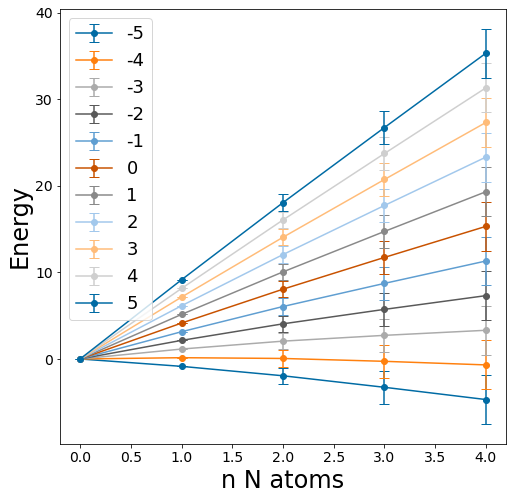

In [741]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1,figsize=(8,8), sharey=False)

x = np.arange(0,5)

for i,potential in enumerate(chemical_potential_all):
    y = energies_all[i]
    print(potential,np.argsort(y))
    #err = std_all[i]
    err = np.array(min_max_all)[i]
    axs.errorbar(x,y,yerr=err/2,fmt='-o',capsize=5,label=np.round(potential,3))
axs.set_xlabel('n N atoms',fontsize=24)
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)
#fig.savefig('./data/chemical_potential/C_1_mu_all.jpg' ,dpi=200)

#### E (multiplicity) vs N n

-2.75 [4 3 2 1 0]
-2.65 [2 4 3 1 0]
-2.55 [2 1 3 0 4]
-2.4499999999999997 [1 2 0 3 4]
-2.3499999999999996 [0 1 2 3 4]


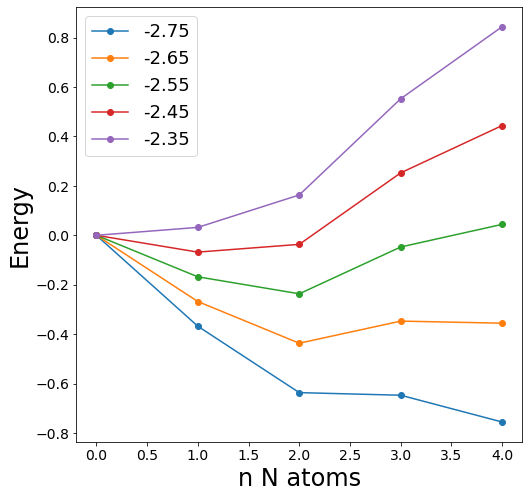

In [42]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1,figsize=(8,8), sharey=False)

x = np.arange(0,5)

for i,potential in enumerate(chemical_potential_all):
    y = energies_all_weight[i]
    print(potential,np.argsort(y))
    #err = std_all[i]
    #err = np.array(min_max_all)[i]
    axs.plot(x,y,marker='o',label=np.round(potential,3))
axs.set_xlabel('n N atoms',fontsize=24)
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)
#fig.savefig('./data/chemical_potential/C_1_mu_all.jpg' ,dpi=200)

#### E vs N min

-2.75 [4 3 2 1 0]
-2.65 [4 3 2 1 0]
-2.55 [4 3 2 1 0]
-2.4499999999999997 [4 3 2 1 0]
-2.3499999999999996 [0 1 2 3 4]


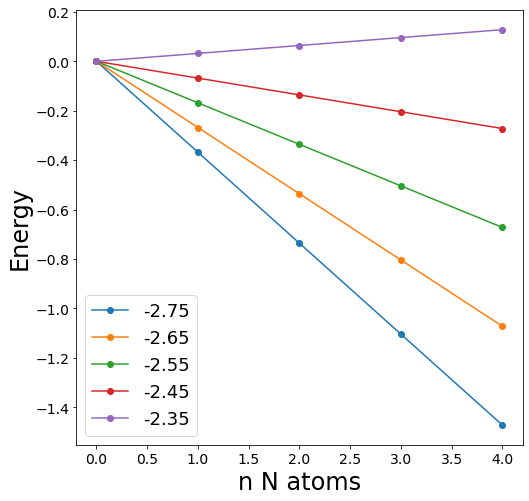

In [149]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1,figsize=(8,8), sharey=False)

x = np.arange(0,5)

for i,potential in enumerate(chemical_potential_all):
    y = energies_all_min[i]
    print(potential,np.argsort(y))

    axs.plot(x,y,marker='o',label=np.round(potential,3))
axs.set_xlabel('n N atoms',fontsize=24)
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)
#fig.savefig('./data/chemical_potential/C_1_mu_all.jpg' ,dpi=200)

#### E (average) vs potential

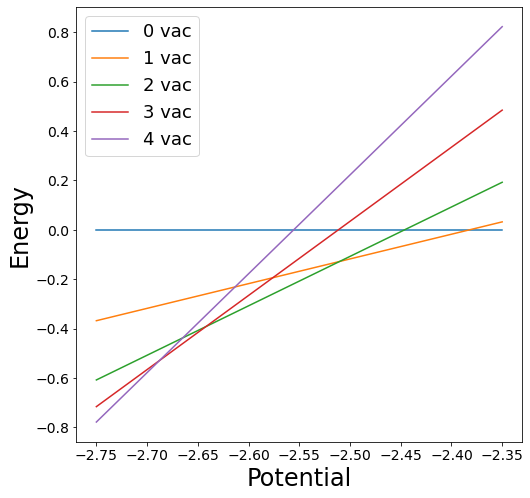

In [44]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1,figsize=(8,8), sharey=False)

x = chemical_potential_all

for i in range(5):
    y = np.array(energies_all)[:,i]
    #print(x,y)
    err = np.array(min_max_all)[i]
    #axs.errorbar(x,y,yerr=err/2,fmt='-o',capsize=5,label=np.round(potential,3))
    axs.plot(x,y,label='%s vac'%i)
axs.set_xlabel('Potential',fontsize=24)
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)

#### E (min) vs potential

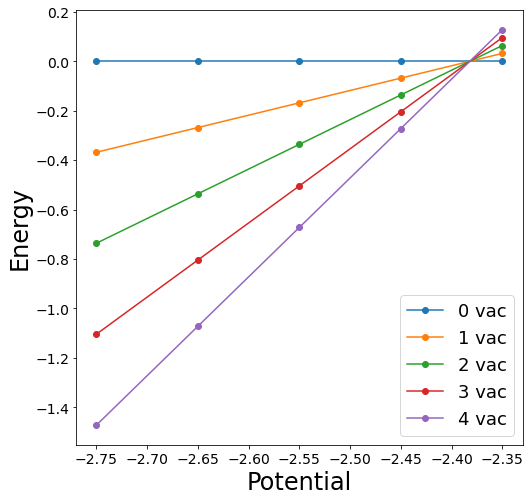

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1,figsize=(8,8), sharey=False)

x = chemical_potential_all

for i in range(5):
    y = np.array(energies_all_min)[:,i]
    #print(x,y)
    #err = np.array(min_max_all)[i]
    #axs.errorbar(x,y,yerr=err/2,fmt='-o',capsize=5,label=np.round(potential,3))
    axs.plot(x,y,marker='o',label='%s vac'%i)
axs.set_xlabel('Potential',fontsize=24)
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)

# <a id='discrete'>Discrete</a>

In [426]:
parameters = [[E_CC_g,E_CN_g,E_NN_g]]
species = [6,7]
build_qubo_discrete_interaction(graphene_32, species, parameters, alpha=1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [103]:
build_qubo_discrete_constraints(graphene_32,[6,7],theta=1.,chem_potential=[0.,0.])

array([[-1.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  2.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.]])

In [74]:
build_discrete_vector([6,6,6,7],2)

array([1, 0, 1, 0, 1, 0, 0, 1])

In [526]:
np.unique(Q_1)

array([-6.801, -6.007, -4.187,  0.   ])

In [774]:
energies_all = []
energies_all_min = []
energies_all_weight = []
std_all = []
min_max_all = []

chemical_potential_all = -np.arange(-2.75,-2.3,0.1)
chemical_potential_all = -np.arange(-3,-2.1,0.1)
#chemical_potential_all = [0]
chemical_potential_all = [-12,-9,-6,-3,0,3,6]
for potential in chemical_potential_all:
    Q_1 = build_qubo_discrete_interaction(graphene_32,[6,7],[[E_CC_g,E_CN_g,E_NN_g]])
    #Q_1 = build_qubo_discrete_interaction(graphene_32,[6,7],[[E_NN_g,E_CN_g,E_CC_g]])
    #Q_1 = build_qubo_binary_interaction(graphene_32,[[E_CC_g,E_CN_g,E_NN_g]])
    #Q_1 = (Q_1 - np.min(Q_1)) / (np.max(Q_1) - np.min(Q_1))
    Q_2 = build_qubo_discrete_constraints(graphene_32,[6,7],chem_potential=[potential,0.],theta=0)
    #Q_2 = build_qubo_discrete_constraints(graphene_32,[6,7],chem_potential=[potential,0.],theta=0)
    #Q_2 = build_qubo_discrete_constraints(graphene_32,[6,7],chem_potential=[0.,potential],theta=0)
    Q = Q_1 + Q_2
    print(Q)
    energies = []
    energies_weight = []
    energies_min = []
    std = []
    min_max = []
    for i,structure_group in enumerate(graphene_all_list):
        atom_configuration_bin = []        

        if isinstance(structure_group, Structure):
            atom_configuration_bin.append(build_discrete_vector(structure_group.atomic_numbers, 2).tolist())
            multiplicity = [multiplicity_all_list[i]]
        else:
            multiplicity = multiplicity_all_list[i]
            for structure in structure_group:
                atom_configuration_bin.append(build_discrete_vector(structure.atomic_numbers, 2).tolist())
        E_qubo = []
        for config_bin in atom_configuration_bin:
            E_qubo.append(classical_energy(config_bin,Q))
        energies_min.append(np.min(np.array(E_qubo)))
        energies.append(np.average(np.array(E_qubo)))
        
        #print(np.array(E_qubo),multiplicity)
        #print(np.average(np.array(E_qubo),weights=multiplicity))
        
        energies_weight.append(np.average(np.array(E_qubo),weights=multiplicity))
        std.append(np.std(np.array(E_qubo)))
        min_max.append(np.max(np.array(E_qubo))-np.min(np.array(E_qubo)))
    energies_all.append(energies)
    energies_all_min.append(energies_min)
    std_all.append(std)
    min_max_all.append(min_max)
    energies_all_weight.append(energies_weight)

[[-12.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. -12. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0. -12.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[-9.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -9. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. -9.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[-6.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -6. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. -6.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[-3.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. -3.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[3. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 

-12 [0 1 2 3 4] [0 1 2 3 4]
-9 [0 1 2 3 4] [0 1 2 3 4]
-6 [0 1 2 3 4] [0 1 2 3 4]
-3 [0 1 2 3 4] [0 1 2 3 4]
0 [0 1 2 3 4] [0 1 2 3 4]
3 [0 1 2 3 4] [4 3 0 2 1]
6 [4 3 2 1 0] [4 3 2 1 0]


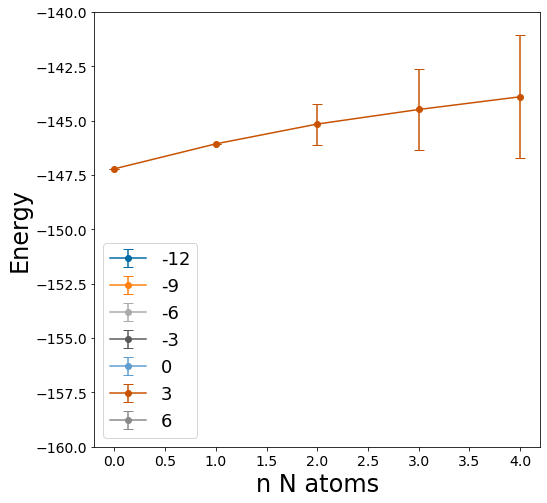

In [779]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1,figsize=(8,8), sharey=False)

x = np.arange(0,5)

for i,potential in enumerate(chemical_potential_all):
    y = energies_all[i]
    #y = energies_all_min[i]
    print(potential,np.argsort(y),np.argsort(energies_all_min[i]))
    #print(np.array(min_max_all)[i])
    #err = std_all[i]
    err = np.array(min_max_all)[i]
    axs.errorbar(x,y,yerr=err/2,fmt='-o',capsize=5,label=np.round(potential,3))
    #axs.plot(x,y,'-o',label=np.round(potential,3))
axs.set_xlabel('n N atoms',fontsize=24)
axs.set_ylim([-160,-140])
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)
#fig.savefig('./data/chemical_potential/C_1_mu_all.jpg' ,dpi=200)

# <a id='chemical_potential_discrete'>Chemical potential discrete</a>

# <a id='QUBO_DFT_energy'>Compare QUBO and DFT energy</a>

In [27]:
cry_energy_2N = []
qubo_energy_2N = []
for i in range(1,4):
    
    n_config = unique_config_2N.shape[0]
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC,E_CN,E_NN]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    q = build_interaction_matrix(structure, [6,7], parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = i)
    #q = build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)

    for i in range(n_config):
        crystal_output = Crystal_output().read_cry_output('./data/crystal/2N/graphene_2N_%s.out'%i)
        crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/2N/graphene_2N_%s.gui'%i)
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = crystal_gui.atom_number
        x = build_discrete_vector(atomic_numbers,num_species=2)
        qubo_energy.append(classical_energy(x,q))
    cry_energy_2N.append(cry_energy)
    qubo_energy_2N.append(qubo_energy)
cry_energy_2N = np.array(cry_energy_2N)   
qubo_energy_2N = np.array(qubo_energy_2N)

In [29]:
df = pd.DataFrame()
df['CRYSTAL E'] = cry_energy_2N[0]



df['QUBO E 1'] = qubo_energy_2N[0]
df['QUBO E 2 '] = qubo_energy_2N[1]
df['QUBO E 3 '] = qubo_energy_2N[2]


df['Delta E 1'] = (qubo_energy_2N[0] - cry_energy_2N[0])
df['Delta E 2 '] = (qubo_energy_2N[1] - cry_energy_2N[0])
df['Delta E 3 '] = (qubo_energy_2N[2] - cry_energy_2N[0])

crystal_E_norm = cry_energy_2N[0] - np.min(cry_energy_2N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_2N[0] - np.min(qubo_energy_2N[0])
qubo2_energy_norm = qubo_energy_2N[1] - np.min(qubo_energy_2N[1])
qubo3_energy_norm = qubo_energy_2N[2] - np.min(qubo_energy_2N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)

std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]

df.loc[len(df.index)] = std

rmse = []
for i in range(0,3):
    rmse.append(np.round(np.sqrt(mean_squared_error(cry_energy_2N[0],qubo_energy_2N[i])),5))
rmse = np.array(rmse)
rmse_pad = np.pad(rmse,(1,len(df.columns)-4))

df.loc[len(df.index)] = rmse_pad
df.rename(index={5: 'STD'},inplace=True)
df.rename(index={6: 'RMSE'},inplace=True)
df = df.round(3)

df = df.round(3)

#dfi.export(df,'./data/images/discrete/df_2N_all_CRY_QUBO.png')
df

,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
0,-19534.861,-19535.181,-19535.012,-19535.012,-0.320,-0.152,-0.152,0.495,0.000,0.168,0.176,-0.495,-0.327,-0.319
1,-19535.029,-19535.181,-19535.181,-19535.181,-0.152,-0.152,-0.152,0.327,0.000,0.000,0.008,-0.327,-0.327,-0.319
2,-19534.156,-19534.155,-19534.155,-19534.155,0.000,0.000,0.000,1.200,1.025,1.025,1.033,-0.174,-0.174,-0.167
3,-19535.037,-19535.181,-19535.181,-19535.181,-0.144,-0.144,-0.144,0.319,0.000,0.000,0.008,-0.319,-0.319,-0.311
4,-19535.355,-19535.181,-19535.181,-19535.189,0.175,0.175,0.167,0.000,0.000,0.000,0.000,0.000,0.000,0.000
STD,0.399,0.410,0.399,0.400,0.166,0.128,0.126,0.399,0.410,0.399,0.400,0.166,0.128,0.126
RMSE,0.000,0.188,0.140,0.138,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


#### 3N

In [30]:
import itertools
X = np.array(list(itertools.product([0, 1], repeat=18)))
three_N = np.where(np.sum(X,axis=1)==15)[0]
X_3 = X[three_N]

In [31]:
all_structures = []
for config in X_3:
    structure = copy.deepcopy(graphene_supercell)
    for j in np.where(config==0)[0]:
        structure.replace(j,7)
    all_structures.append(structure)    


In [32]:
from pymatgen.analysis.structure_matcher import StructureMatcher

#Find the unique structures
unique_structures = StructureMatcher().group_structures(all_structures)

unique_structures_label = []

#Find to which class the structures belong to
for structure in all_structures:
    for i in range(len(unique_structures)):
        #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
        if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
            unique_structures_label.append(i)
            break

In [33]:
np.unique(unique_structures_label,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 18, 108,  30,   6, 127,  79,  83,  92,  75,  30,   6,  63,  50,
         49]))

In [34]:
index_3 = np.unique(unique_structures_label,return_index=True)[1]

In [35]:
unique_config_3N = X_3[index_3]

In [37]:
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,j in enumerate(index_3):
    crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

    structure = all_structures[j]
    #print(structure)
    crystal_gui = cry_pmg2gui(structure,dimensionality=2)
    crystal_gui.write_crystal_gui('./data/crystal/3N/graphene_32_3N_%s.gui'%i)
    crystal_input.write_crystal_input('./data/crystal/3N/graphene_32_3N_%s.d12'%i)
    
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_32_3N_%s\n'%i)
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_32_3N_%s\n'%i)
    data.append('\n\n')

    
with open('./data/crystal/3N/graphene_32_3N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)


#### output

In [38]:
cry_energy_3N = []
qubo_energy_3N = []
for j in range(1,4):    
    n_config = unique_config_3N.shape[0]
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC,E_CN,E_NN]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    q = build_interaction_matrix(structure, [6,7], parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = j)
    #q = build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)

    for i in range(n_config):
        crystal_output = Crystal_output().read_cry_output('./data/crystal/3N/graphene_3N_%s.out'%i)
        crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/3N/graphene_3N_%s.gui'%i)
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = crystal_gui.atom_number
        #print(crystal_gui.atom_number)
        x = build_discrete_vector(atomic_numbers,num_species=2)
        qubo_energy.append(classical_energy(x,q))
        #print(np.round(classical_energy(x,q),5),np.round(crystal_output.get_final_energy(),5),classical_energy(x,q)-crystal_output.get_final_energy())
    cry_energy_3N.append(cry_energy)
    qubo_energy_3N.append(qubo_energy)

cry_energy_3N = np.array(cry_energy_3N)   
qubo_energy_3N = np.array(qubo_energy_3N)

In [39]:
df = pd.DataFrame()
df['CRYSTAL E'] = cry_energy_3N[0]

df['QUBO E 1'] = qubo_energy_3N[0]
df['QUBO E 2 '] = qubo_energy_3N[1]
df['QUBO E 3 '] = qubo_energy_3N[2]

df['Delta E 1'] = (qubo_energy_3N[0] - cry_energy_3N[0])
df['Delta E 2 '] = (qubo_energy_3N[1] - cry_energy_3N[0])
df['Delta E 3 '] = (qubo_energy_3N[2] - cry_energy_3N[0])

crystal_E_norm = cry_energy_3N[0] - np.min(cry_energy_3N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_3N[0] - np.min(qubo_energy_3N[0])
qubo2_energy_norm = qubo_energy_3N[1] - np.min(qubo_energy_3N[1])
qubo3_energy_norm = qubo_energy_3N[2] - np.min(qubo_energy_3N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)
df = df.sort_values('CRY E norm')
df.loc[len(df.index)] = std


std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]



rmse = []
for i in range(0,3):
    rmse.append(np.round(np.sqrt(mean_squared_error(cry_energy_3N[0],qubo_energy_3N[i])),5))
rmse = np.array(rmse)
rmse_pad = np.pad(rmse,(1,len(df.columns)-4))

df.loc[len(df.index)] = rmse_pad
df.rename(index={14: 'STD'},inplace=True)
df.rename(index={15: 'RMSE'},inplace=True)
df = df.round(3)

#dfi.export(df,'./data/images/discrete/df_3N_all_CRY_QUBO.png')
df

,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
9,-19986.631,-19986.541,-19986.373,-19986.389,0.090,0.258,0.242,0.000,0.000,0.168,0.160,0.000,0.168,0.160
13,-19986.461,-19986.541,-19986.541,-19986.549,-0.080,-0.080,-0.087,0.169,0.000,0.000,0.000,-0.169,-0.169,-0.169
7,-19986.367,-19986.541,-19986.373,-19986.381,-0.174,-0.005,-0.013,0.263,0.000,0.168,0.168,-0.263,-0.095,-0.095
10,-19986.185,-19986.541,-19986.541,-19986.541,-0.356,-0.356,-0.356,0.446,0.000,0.000,0.008,-0.446,-0.446,-0.438
6,-19986.039,-19986.541,-19986.373,-19986.373,-0.502,-0.334,-0.334,0.592,0.000,0.168,0.176,-0.592,-0.424,-0.416
1,-19985.961,-19986.541,-19986.204,-19986.204,-0.580,-0.244,-0.244,0.670,0.000,0.337,0.344,-0.670,-0.333,-0.326
3,-19985.935,-19986.541,-19986.036,-19986.036,-0.606,-0.101,-0.101,0.695,0.000,0.505,0.513,-0.695,-0.191,-0.183
0,-19985.808,-19986.541,-19986.036,-19986.036,-0.733,-0.228,-0.228,0.823,0.000,0.505,0.513,-0.823,-0.318,-0.310
2,-19985.747,-19986.541,-19986.036,-19986.036,-0.794,-0.289,-0.289,0.883,0.000,0.505,0.513,-0.883,-0.378,-0.371
11,-19985.590,-19985.516,-19985.516,-19985.524,0.074,0.074,0.066,1.041,1.025,1.025,1.025,-0.016,-0.016,-0.016


# <a id='anneal'>Run the anneal</a>

### Interaction energy

In [104]:
species=[6,7]
#parameters = [[E_CC_g,E_CN_g,E_NN_g],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
parameters = [[E_CC_g,E_CN_g,E_NN_g]]
parameters = [[E_NN_g,E_CN_g,E_CC_g]]
#Q_interaction = build_interaction_matrix(structure, species, parameters = parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = 2)
Q_interaction = build_qubo_binary_interaction(graphene_32, parameters)#, alpha=1, max_neigh = 1)

#np.round(Q_interaction,5)[0:20,0:20]

In [105]:
Q_interaction

array([[-5.46,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , -5.46,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -5.46, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ..., -5.46,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , -5.46,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  , -5.46]])

### Chemical potential

In [140]:
Q_constraint = build_qubo_binary_constraints(graphene_32,chem_potential=-2.382)
Q_constraint = build_qubo_binary_constraints(graphene_32,chem_potential=+4.)
Q_constraint

array([[4., 0., 0., ..., 0., 0., 0.],
       [0., 4., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 4., 0., 0.],
       [0., 0., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

In [141]:
Q = Q_interaction + Q_constraint

In [142]:
Q

array([[-1.46,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.46,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.46, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ..., -1.46,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , -1.46,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  , -1.46]])

In [143]:
from dwave.system import EmbeddingComposite, DWaveSampler

sampler = EmbeddingComposite(DWaveSampler())

sampleset = sampler.sample_qubo(Q, num_reads=1000)

In [144]:
sampleset.to_pandas_dataframe()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0.00000,-23.360,607
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0.00000,-23.360,384
2,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0.00000,-21.900,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0.00000,-21.900,1
4,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0.00000,-21.900,1
5,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0.00000,-21.900,1
6,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,0.00000,-21.900,1
7,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0.00000,-21.900,1
8,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0.00000,-21.742,1
9,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0.00000,-21.742,1


# <a id='anneal_binary'>Run the anneal (binary)</a>

In [100]:
#optimised cell
lattice = np.array([[  0.212090484210E+01, -0.122450498151E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.244900996303E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.000000000000E+00,  0.500000000000E+03]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_18 = copy.deepcopy(graphene)
graphene_18.make_supercell(scaling_matrix)
#structure = graphene_32

# #number of atoms
# N_C_g = graphene_18.num_sites
# #number of bonds
# N_CC_g = N_C_g*1.5

In [137]:
from dwave.system import EmbeddingComposite, DWaveSampler

sampler = EmbeddingComposite(DWaveSampler())

Q_interaction_binary = build_qubo_binary_interaction(graphene_18,[[E_CC_g,E_CN_g,E_NN_g]])
chemical_potential_all = [-6,-3,0]

df_list = []
for potential in chemical_potential_all:
    Q_constraint_binary = build_qubo_binary_constraints(graphene_18,chem_potential=float(potential))
    Q_binary = Q_interaction_binary + Q_constraint_binary
    #print(Q_constraint_binary[0:10,0:10])
    sampleset = sampler.sample_qubo(Q_binary, num_reads=1000)
    df_list.append(sampleset.to_pandas_dataframe())

In [144]:
df_list[0]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0.0,-16.676210,695
1,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,0.0,-16.676210,292
2,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0.0,-15.862948,2
3,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0.0,-15.862948,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0.0,-15.862948,1
5,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,1,0,0,0.0,-15.862948,1
6,0,0,0,0,1,0,0,0,0,1,...,1,1,1,1,1,1,1,0.0,-15.862948,1
7,1,1,1,1,1,1,1,1,1,0,...,0,0,0,1,0,0,0,0.0,-15.862948,1
8,1,1,1,1,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0.0,-15.862948,2
9,0,0,0,1,0,0,0,0,0,1,...,1,1,1,1,1,1,1,0.0,-15.862948,1


<function matplotlib.pyplot.show(close=None, block=None)>

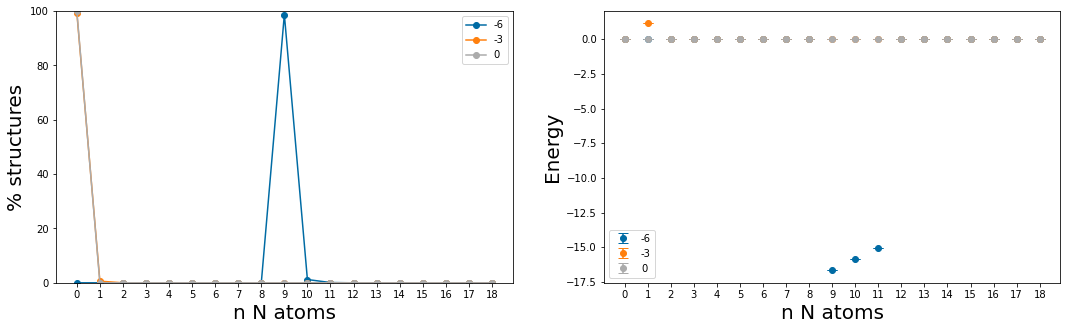

In [151]:
import os
import matplotlib.pyplot as plt
import csv
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/discrete/test_potential/test_tall_all_pot/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = np.arange(-10,21,1)


fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
#fig.suptitle('Theta = %s'%theta, fontsize=20)
for i,potential in enumerate(chemical_potential_all):
    total_multiplicity = []
    df = df_list[i]
    multiplicities = df['num_occurrences'].to_numpy()
    total_reads = np.sum(df['num_occurrences'].to_numpy())
    energy = df['energy'].to_numpy()
    sum_vector = np.sum(df.iloc[:,0:18],axis=1)
    energy_average = np.zeros(19)
    energy_min_max = np.zeros(19)
    energy_std = []
    for i,n_N in enumerate(range(19)):
        #print(energy[np.where(sum_vector == n_N)[0]])
        if len(energy[np.where(sum_vector == n_N)[0]]) >0:
            energy_average[i] =np.average(energy[np.where(sum_vector == n_N)[0]],weights=multiplicities[np.where(sum_vector == n_N)[0]])
            energy_min_max[i] = np.max(energy[np.where(sum_vector == n_N)[0]]) - np.min(energy[np.where(sum_vector == n_N)[0]])
            #display(df)
    unique_energies = np.unique(energy)
    unique_energies_mult = []

    for unique_energy in unique_energies:
        unique_energies_mult = np.sum(multiplicities[np.where(energy==unique_energy)[0]])
        #unique_energies_mult.append(np.sum())
    multiplicity = df['num_occurrences'].to_numpy()
    total_multiplicity.append(np.sum(multiplicity))
    ratio_structures = []
    for k in range(0,19):
        ratio_structures.append((np.sum(multiplicity[np.where(sum_vector == k)])/total_reads)*100)
    axs[0].plot(np.arange(19),ratio_structures,'-o',label=potential)#label=potential)
#     for unique_energy in unique_energies:
#         axs[1].plot(unique_energy,unique_energies_mult,'-o')
    axs[1].errorbar(np.arange(19),energy_average,yerr=energy_min_max/2,fmt='o',capsize=5,label=np.round(potential,3))
axs[0].set_xticks(np.arange(19))
axs[0].set_xlabel('n N atoms',fontsize=20)
axs[0].set_ylabel('% structures',fontsize=20)
axs[1].set_xlabel('n N atoms',fontsize=20)
axs[1].set_ylabel('Energy',fontsize=20)
axs[1].set_xticks(np.arange(19))
axs[0].set_ylim([0,100])
#axs[1].set_ylim([-1000,-550])
#axs[1].set_ylim([-680,-600])
axs[0].legend()
axs[1].legend()
#axs[1].plot(potential_range,total_multiplicity,'-o')
#axs[1].plot(potential_range,theta_range,'-o')
plt.show

# <a id='anneal_discrete'>Run the anneal (discrete)</a>

In [253]:
#optimised cell
lattice = np.array([[  0.212090484210E+01, -0.122450498151E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.244900996303E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.000000000000E+00,  0.500000000000E+03]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_18 = copy.deepcopy(graphene)
graphene_18.make_supercell(scaling_matrix)
#structure = graphene_32

# #number of atoms
# N_C_g = graphene_18.num_sites
# #number of bonds
# N_CC_g = N_C_g*1.5

In [254]:
from dwave.system import EmbeddingComposite, DWaveSampler

sampler = EmbeddingComposite(DWaveSampler())

Q_interaction_discrete = build_qubo_discrete_interaction(graphene_18,[6,7],[[E_CC_g,E_CN_g,E_NN_g]])
chemical_potential_all = [-12,-9,-6,-3,0,3,6]

df_list = []
for potential in chemical_potential_all:
    Q_constraint_discrete = build_qubo_discrete_constraints(graphene_18,[6,7],chem_potential=[potential,0.],theta=30)
    Q_discrete = Q_interaction_discrete + Q_constraint_discrete
    
    sampleset = sampler.sample_qubo(Q_discrete, num_reads=1000)
    df_list.append(convert_discrete_df(sampleset.to_pandas_dataframe(),2,[6,7]))

<function matplotlib.pyplot.show(close=None, block=None)>

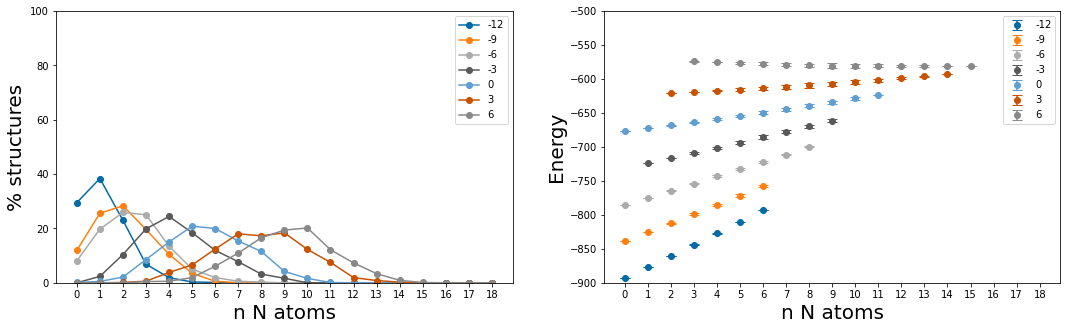

In [261]:
import os
import matplotlib.pyplot as plt
import csv
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/discrete/test_potential/test_tall_all_pot/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = np.arange(-10,21,1)


fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
#fig.suptitle('Theta = %s'%theta, fontsize=20)
for i,potential in enumerate(chemical_potential_all):
    total_multiplicity = []
    df = df_list[i]
    multiplicities = df['num_occurrences'].to_numpy()
    total_reads = np.sum(df['num_occurrences'].to_numpy())
    energy = df['energy'].to_numpy()
    sum_vector = np.sum(df.iloc[:,0:18]==7,axis=1)
    energy_average = np.zeros(19)
    energy_min_max = np.zeros(19)
    energy_std = []
    for i,n_N in enumerate(range(19)):
        #print(energy[np.where(sum_vector == n_N)[0]])
        if len(energy[np.where(sum_vector == n_N)[0]]) >0:
            energy_average[i] =np.average(energy[np.where(sum_vector == n_N)[0]],weights=multiplicities[np.where(sum_vector == n_N)[0]])
            energy_min_max[i] = np.max(energy[np.where(sum_vector == n_N)[0]]) - np.min(energy[np.where(sum_vector == n_N)[0]])
            #display(df)
    unique_energies = np.unique(energy)
    unique_energies_mult = []

    for unique_energy in unique_energies:
        unique_energies_mult = np.sum(multiplicities[np.where(energy==unique_energy)[0]])
        #unique_energies_mult.append(np.sum())
    multiplicity = df['num_occurrences'].to_numpy()
    total_multiplicity.append(np.sum(multiplicity))
    ratio_structures = []
    for k in range(0,19):
        ratio_structures.append((np.sum(multiplicity[np.where(sum_vector == k)])/total_reads)*100)
    axs[0].plot(np.arange(19),ratio_structures,'-o',label=potential)#label=potential)
#     for unique_energy in unique_energies:
#         axs[1].plot(unique_energy,unique_energies_mult,'-o')
    axs[1].errorbar(np.arange(19),energy_average,yerr=energy_min_max/2,fmt='o',capsize=5,label=np.round(potential,3))
axs[0].set_xticks(np.arange(19))
axs[0].set_xlabel('n N atoms',fontsize=20)
axs[0].set_ylabel('% structures',fontsize=20)
axs[1].set_xlabel('n N atoms',fontsize=20)
axs[1].set_ylabel('Energy',fontsize=20)
axs[1].set_xticks(np.arange(19))
axs[0].set_ylim([0,100])
#axs[1].set_ylim([-1000,-550])
axs[1].set_ylim([-900,-500])
axs[0].legend()
axs[1].legend()
#axs[1].plot(potential_range,total_multiplicity,'-o')
#axs[1].plot(potential_range,theta_range,'-o')
plt.show

# <a id='symm_eq_structures'>Identify symmetry equivalent structures</a>

In [357]:
def find_symmetry_equivalent_structures_desc(dataframe, structure, remove_unfeasible = False, species=None ,concentration=None):
    #spglib-based analysis

    
    #Concentration follows the order given in species
    
    import copy 
    
    
    df = dataframe
    
    num_sites = structure.num_sites
    lattice = structure.lattice
    atom_position = structure.cart_coords
    
    '''if concentration is not None and species is not None:
        feasible_config = []
        all_config = df.iloc[:,0:num_sites].to_numpy()
        #sum_vector = np.sum(all_config,axis=1)
        #feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]
        for config in all_config:
            feasible = True
            for i in range(len(concentration)):
                feasible *= np.sum(config == species[i]) == concentration[i] 
            #print(feasible)
            feasible_config.append(feasible) 
        
        df = df.iloc[feasible_config,:]'''
    
    if remove_unfeasible == True and species is not None and concentration is not None:
        df = remove_unfeasible_solutions(dataframe,species,concentration)
    
    #configurations = df.iloc[:,0:num_sites].to_numpy()
    
    multiplicity = df['num_occurrences'].to_numpy()
    chain_break = df['chain_break_fraction'].to_numpy()
    energies = df['energy'].to_numpy()


    '''#Replace the C atom with an H atom where the vacancies are
    zero_elements = np.where(configurations == 0) 
    configurations[zero_elements] = 99'''
    
    all_structures = df2structure(df,structure)
    '''for config in configurations:
        all_structures.append(Structure(lattice, config, atom_position, coords_are_cartesian=True))'''

    
    #Build the descriptor - WIP
    from dscribe.descriptors import SineMatrix

    # Setting up the sine matrix descriptor
    structures_ase = [AseAtomsAdaptor().get_atoms(structure) for structure in structures]
    sm = SineMatrix(
        n_atoms_max=num_sites,
        permutation="eigenspectrum",
        sparse=False
    )
    sm_all = sm.create(structures_ase) 
    
    descriptor = np.round(sm.create(structures_ase),5)

    descriptor_unique, descriptor_first, descriptor_count = \
    np.unique(descriptor, axis=0,return_counts=True, return_index=True)

    group_structures = []
    for desc in descriptor_unique:
        structure_desc = []
        for i,d in enumerate(descriptor):
            if np.all(np.array(desc) == np.array(d)):
                structure_desc.append(i)
        group_structures.append(structure_desc)

    
    unique_multiplicity = []
    unique_chain_break = []
    unique_structure_index = []
    
    for x in group_structures:
        unique_structure_index.append(x[0])
        unique_multiplicity.append(np.sum(multiplicity[x]))
        unique_chain_break.append(np.average(chain_break[x],weights=multiplicity[x]))    
    
    df = df.iloc[unique_structure_index].copy()
    
    if len(df) == len(unique_multiplicity):
        df['num_occurrences'] = unique_multiplicity
        df['chain_break_fraction'] = unique_chain_break
        
        return df
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None

In [369]:
df_desc = find_symmetry_equivalent_structures_desc(ddf,graphene_18)

IndexError: index 13 is out of bounds for axis 0 with size 13

In [367]:
ddf_symm = find_symmetry_equivalent_structures(df_desc,graphene_18)

In [371]:
np.sum(ddf['num_occurrences'])

887

### Coulomb matrix

In [266]:
len(df2structure(df_list[0],graphene_18) )

173

In [340]:
structures

[Structure Summary
 Lattice
     abc : 7.347029889079535 7.347029889079535 500.0
  angles : 90.0 90.0 120.00000000000001
  volume : 23373.52690022699
       A : 3.6735149445397672 -6.362714526306444 0.0
       B : 3.6735149445397672 6.362714526306444 0.0
       C : 0.0 0.0 500.0
 PeriodicSite: C (1.2245, -0.7070, 0.0000) [0.2222, 0.1111, 0.0000]
 PeriodicSite: C (2.4490, 1.4139, 0.0000) [0.2222, 0.4444, 0.0000]
 PeriodicSite: C (3.6735, 3.5348, 0.0000) [0.2222, 0.7778, 0.0000]
 PeriodicSite: C (2.4490, -2.8279, 0.0000) [0.5556, 0.1111, 0.0000]
 PeriodicSite: C (3.6735, -0.7070, 0.0000) [0.5556, 0.4444, 0.0000]
 PeriodicSite: C (4.8980, 1.4139, 0.0000) [0.5556, 0.7778, 0.0000]
 PeriodicSite: C (3.6735, -4.9488, 0.0000) [0.8889, 0.1111, 0.0000]
 PeriodicSite: C (4.8980, -2.8279, 0.0000) [0.8889, 0.4444, 0.0000]
 PeriodicSite: C (6.1225, -0.7070, 0.0000) [0.8889, 0.7778, 0.0000]
 PeriodicSite: C (1.2245, 0.7070, 0.0000) [0.1111, 0.2222, 0.0000]
 PeriodicSite: C (2.4490, 2.8279, 0.0000) [0

In [337]:
structures = df2structure(df_list[0],graphene_18)
structures_ase = [AseAtomsAdaptor().get_atoms(structure) for structure in structures]

In [277]:
from dscribe.descriptors import CoulombMatrix

cm = CoulombMatrix(n_atoms_max=18,permutation='eigenspectrum')
cm_all = cm.create(structures_ase)

In [318]:
n_N = []

for structure in structures:
    n_N.append(np.sum(np.array(structure.atomic_numbers) == 7))
    #print(np.array(structure.atomic_numbers),np.sum(np.array(structure.atomic_numbers) == 7))
n_N = np.array(n_N)

In [320]:
for i in range(18):
    for j in np.where(n_N == i)[0]:
        print(i,j)
        print(cm_all[j])

0 0
[242.78208263  91.59408501  66.43469697  55.06089426  35.54635691
  34.96090917  31.22758488  22.21508194  20.84097867  16.93173045
  12.57343309   8.94087869   7.20547801   7.1865886    4.54902974
   3.67449577   2.07272867  -0.35113989]
1 1
[ 2.49347726e+02  9.33629659e+01  6.84950017e+01  5.54150881e+01
  3.84152119e+01  3.51917045e+01  3.12753128e+01  2.24566231e+01
  2.08682271e+01  1.71161698e+01  1.28315820e+01  8.95844660e+00
  8.37538793e+00  7.19268464e+00  4.56078192e+00  4.00302897e+00
  2.25739259e+00 -1.76839239e-01]
1 2
[245.45045702  94.90806765  66.43469697  58.8116143   37.79892708
  35.54635691  31.2740561   23.45679759  22.21508194  17.82058017
  12.57343309   8.94089427   7.4084428    7.20547801   4.67836484
   3.67449577   2.09769815  -0.34894687]
1 3
[247.66297083  95.28832928  67.19823237  55.80058346  37.52638881
  34.97062686  31.24205248  24.407275    21.19165916  17.35885213
  13.21594113   8.94502114   7.51996329   7.1882       4.75389344
   3.72448708 

### Sine matrix

In [338]:
from dscribe.descriptors import SineMatrix

# Setting up the sine matrix descriptor
sm = SineMatrix(
    n_atoms_max=18,
    permutation="eigenspectrum",
    sparse=False
)
sm_all = sm.create(structures_ase) 

In [339]:
np.unique(np.round(sm_all,5),axis=0, return_counts=True)

(array([[196.80327,  69.40357,  69.40357,  69.40357,  69.40357,  64.68419,
          64.68419,  57.89833,  57.89833, -18.55502,  -8.75386,  -8.75386,
          -8.75386,  -8.75386,  -4.03448,  -4.03448,   2.75138,   2.75138],
        [201.33808,  78.55502,  69.40357,  69.40357,  69.40357,  65.87879,
          64.68419,  59.13557,  57.89833, -18.71803,  -8.75386,  -8.75386,
          -8.75386,  -8.74873,  -4.03448,  -3.88334,   3.1406 ,   2.75138],
        [205.67423,  82.23105,  74.24943,  69.40357,  69.40357,  67.87177,
          64.68419,  59.46829,  58.83137, -18.87719,  -8.75386,  -8.75386,
          -8.75266,  -8.7444 ,  -4.03448,  -3.7347 ,   3.2295 ,   3.05128],
        [205.6869 ,  80.43681,  77.06555,  69.40357,  69.40357,  66.50751,
          65.25121,  59.75587,  58.28659, -18.88256,  -8.75386,  -8.75386,
          -8.74925,  -8.74821,  -3.95808,  -3.81039,   3.45201,   2.85371],
        [205.69208,  82.03935,  74.84222,  69.40357,  69.40357,  65.90687,
          65.80536,  

In [312]:
structures_ase[0]

Atoms(symbols='C18', pbc=True, cell=[[3.6735149445397672, -6.362714526306444, 0.0], [3.6735149445397672, 6.362714526306444, 0.0], [0.0, 0.0, 500.0]])

In [313]:
structures_ase[1]

Atoms(symbols='C5NC12', pbc=True, cell=[[3.6735149445397672, -6.362714526306444, 0.0], [3.6735149445397672, 6.362714526306444, 0.0], [0.0, 0.0, 500.0]])

In [285]:
cm_all[0]

array([242.78208263,  91.59408501,  66.43469697,  55.06089426,
        35.54635691,  34.96090917,  31.22758488,  22.21508194,
        20.84097867,  16.93173045,  12.57343309,   8.94087869,
         7.20547801,   7.1865886 ,   4.54902974,   3.67449577,
         2.07272867,  -0.35113989])

In [291]:
np.round(cm_all[3])

array([248.,  95.,  67.,  56.,  38.,  35.,  31.,  24.,  21.,  17.,  13.,
         9.,   8.,   7.,   5.,   4.,   2.,  -0.])

### Symmetry analysis

In [348]:
df_symmetry = find_symmetry_equivalent_structures(df_list[1], graphene_18, remove_unfeasible = False, species=None ,concentration=None,)

In [349]:
df_symmetry

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
592,6,6,7,6,6,6,7,6,6,6,...,6,7,7,7,6,6,6,0.000000,-758.148663,4
543,6,6,6,6,6,6,6,6,6,7,...,6,7,7,6,6,6,7,0.000000,-773.073199,24
411,6,6,7,6,6,6,7,6,7,6,...,6,7,6,6,6,6,6,0.000386,-786.220287,72
210,6,7,6,6,6,6,6,6,6,6,...,6,7,6,6,7,6,6,0.000000,-799.367375,130
211,6,6,6,6,6,6,6,6,6,6,...,6,6,6,7,7,6,6,0.000000,-799.367375,5
35,6,6,7,6,6,6,6,6,6,6,...,6,6,6,6,7,6,6,0.000285,-812.514463,195
1,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,7,6,6,0.000158,-825.661551,176
0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,0.000000,-838.808639,82


In [628]:
atoms_list = df_list[6].iloc[:,0:18].to_numpy()
build_discrete_vector(build_binary_vector(atoms_list[0],[7,6]))

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [643]:
discrete_vector = np.empty((atoms_list.shape[0],36))
n_N = []
for i,line in enumerate(atoms_list):
    n_N.append(np.sum(build_binary_vector(line,[7,6])))
    discrete_vector[i,:] = build_discrete_vector(build_binary_vector(line,[7,6]))

In [633]:
Q_constraint_discrete = build_qubo_discrete_constraints(graphene_18,[6,7],chem_potential=[3.,0.],theta=30)
Q_discrete = Q_interaction_discrete + Q_constraint_discrete

In [654]:
energies = []
for line in discrete_vector:
    energies.append(classical_energy(line,Q_discrete))
energies = np.array(energies)

In [671]:
energy_N = np.zeros(19)
min_max = np.zeros(19)
min = np.zeros(19)
for i in range(19):
    e = energies[np.where(np.array(n_N) == i)[0]]
    if len(e) > 0:
        energy_N[i] = (np.average(e))
        min_max[i] = (np.max(e)-np.min(e))
        min[i] = np.min(e)
    #print(energies[np.where(np.array(n_N) == i)[0]])

(-680.0, -650.0)

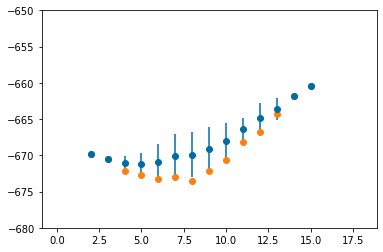

In [674]:
plt.errorbar(range(19),energy_N,yerr=min_max/2,fmt='o')
#plt.plot(range(19),min,'o')
plt.ylim([-680,-650])

0
1
2
3
4
5
6


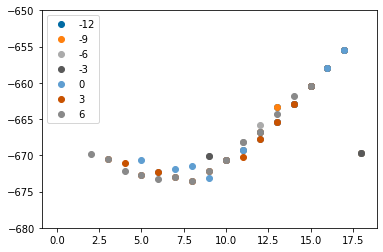

In [688]:
for i,potential in enumerate(chemical_potential_all):
    print(i)
    atoms_list = df_list[i].iloc[:,0:18].to_numpy()
    build_discrete_vector(build_binary_vector(atoms_list[0],[7,6]))

    discrete_vector = np.empty((atoms_list.shape[0],36))
    n_N = []
    for i,line in enumerate(atoms_list):
        n_N.append(np.sum(build_binary_vector(line,[7,6])))
        discrete_vector[i,:] = build_discrete_vector(build_binary_vector(line,[7,6]),2)

    Q_constraint_discrete = build_qubo_discrete_constraints(graphene_18,[6,7],chem_potential=[3.,0.],theta=30)
    Q_discrete = Q_interaction_discrete + Q_constraint_discrete

    energies = []
    for line in discrete_vector:
        energies.append(classical_energy(line,Q_discrete))
    energies = np.array(energies)
    
    energy_N = np.zeros(19)
    min_max = np.zeros(19)
    min = np.zeros(19)
    for i in range(19):
        e = energies[np.where(np.array(n_N) == i)[0]]
        if len(e) > 0:
            energy_N[i] = (np.average(e))
            min_max[i] = (np.max(e)-np.min(e))
            min[i] = np.min(e)
    #plt.errorbar(range(19),energy_N,yerr=min_max/2,fmt='o')
    plt.plot(range(19),min,'o',label=potential)
plt.ylim([-680,-650])
plt.legend()

# Test potential (now binary)

In [7]:
from dimod.binary import BinaryQuadraticModel
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.embedding.chain_strength import  uniform_torque_compensation
from dimod.binary import BinaryQuadraticModel
import dwave.inspector
import csv


In [18]:
num_sites = graphene_supercell.num_sites

Q_interaction = build_qubo_binary_interaction(graphene_supercell,[[E_CC,E_CN,E_NN]])

energies_all = []
std_all = []
min_max_all = []

#chemical_potential_all = np.arange(1.4,1.6,0.02)
chemical_potential_all = np.arange(-5,-2.1,0.5)

#chemical_potential_all = np.arange(0,3,0.25)
#chemical_potential_all = [0]
for chemical_potential in chemical_potential_all:    
    Q_potential = build_qubo_binary_constraints(structure,chem_potential=float(chemical_potential))
    Q = (Q_interaction+Q_potential)
    #print(np.diag(Q))
    df_qubo = qubo_classical_solver(Q)
    num_atoms = np.sum(df_qubo.iloc[:,0:num_sites].to_numpy(),axis=1)

    energies = []
    std = []
    min_max = []
    for i in range(0,num_sites+1):
        structure_n = np.where(num_atoms == i)[0]
        energies_tmp = df_qubo.iloc[structure_n.tolist()]['Energy'].to_numpy()  
        #####display(df_qubo.iloc[structure_n.tolist()])

        energies.append(np.average(energies_tmp))
        std.append(np.std(energies_tmp))
        min_max.append(np.max(energies_tmp)-np.min(energies_tmp))

    energies_all.append(energies)
    std_all.append(std)
    min_max_all.append(min_max)

energies_all = np.array(energies_all)
std_all = np.array(std_all)
min_max_all = np.array(min_max_all)

energies_all_norm = energies_all       

In [6]:
def qubo_binary_energy_analysis(Q):
    
    energies_all = []
    std_all = []
    min_max_all = []

    num_sites = Q.shape[0]
    df_qubo = qubo_classical_solver(Q)
    num_atoms = np.sum(df_qubo.iloc[:,0:num_sites].to_numpy(),axis=1)

    energies = []
    std = []
    min_max = []
    for i in range(0,num_sites+1):
        structure_n = np.where(num_atoms == i)[0]
        energies_tmp = df_qubo.iloc[structure_n.tolist()]['Energy'].to_numpy()  
        #####display(df_qubo.iloc[structure_n.tolist()])

        energies.append(np.average(energies_tmp))
        std.append(np.std(energies_tmp))
        min_max.append(np.max(energies_tmp)-np.min(energies_tmp))

    return energies, std, min_max



[15 14 16 13 17 12 18 11 10  9  8  7  6  5  4  3  2  1  0]
[12 13 11 14 10 15  9 16  8 17  7 18  6  5  4  3  2  1  0]
[ 9 10  8 11  7 12  6 13  5 14  4 15  3 16  2 17  1 18  0]
[ 7  6  8  5  9  4 10  3 11  2 12  1 13  0 14 15 16 17 18]
[ 4  3  5  2  6  1  7  0  8  9 10 11 12 13 14 15 16 17 18]
[ 1  2  0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


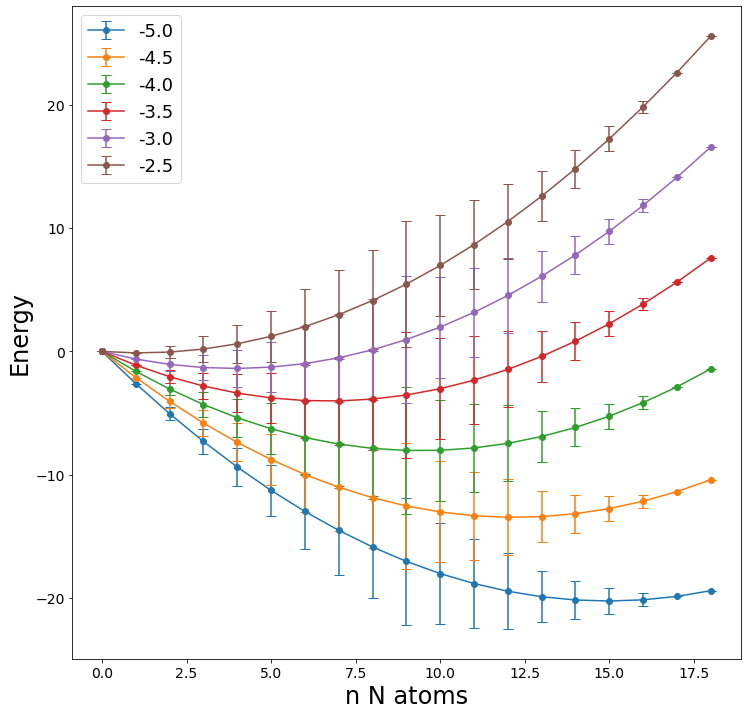

In [25]:
import matplotlib.pyplot as plt
num_sites = 18
fig, axs = plt.subplots(1,1,figsize=(12, 12), sharey=False)
x = range(0,num_sites+1)
for i,potential in enumerate(chemical_potential_all):
    y = energies_all[i]
    print(np.argsort(y))
    #err = std_all[i]
    err = min_max_all[i]
    ##print(err)
    axs.errorbar(x,y,yerr=err/2,fmt='-o',capsize=5,label=potential)
axs.set_xlabel('n N atoms',fontsize=24)
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)
fig.savefig('./data/chemical_potential/C_1_mu_all.jpg' ,dpi=200)

In [8]:
file_path = './data/discrete/binary/test_potential/'
parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
potential_range_1 = np.arange(-5,-2.1,1.)
potential_range = []
theta_range = []
# for theta in [10]:
#     n_C = structure.num_sites - n_N
#     potential_range = []
for i,potential in enumerate(potential_range_1):

    q1 = build_qubo_binary_interaction(structure, parameters, max_neigh = 1)
    potential_range.append(potential)

    chem_potential = float(potential)
    
    q2 = build_qubo_binary_constraints(structure,chem_potential=chem_potential) 
    
    Q= q1+q2

    sampler = EmbeddingComposite(DWaveSampler())

    bqm = BinaryQuadraticModel.from_qubo(Q)

    chain_strength = uniform_torque_compensation(bqm, prefactor=0.3)

    sampleset = sampler.sample(bqm, chain_strength=chain_strength,num_reads=1000)

    save_json_binary_potential(structure,sampleset, bqm, index = str(i),
                     label='Test anneal', file_path = file_path, file_name = 'Ngraphene', save_qubo = True,
                    chain_strength = chain_strength, potential=potential)



with open(file_path+'potential_range.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(potential_range)


In [9]:
sampleset

SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], -5.54922106, 588, 0.),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], -5.54922106, 342, 0.),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1], -4.93264094,   4, 0.),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], -4.93264094,   6, 0.),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1], -4.93264094,   4, 0.),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], -4.93264094,   3, 0.),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], -4.93264094,   4, 0.),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1], -4.93264094,   3, 0.),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -4.93264094,   5, 0.),
           ([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], -4.93264094,   4, 0.),
           ([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], -4.93264094,

NameError: name 'qubo_binary_energy_analysis' is not defined

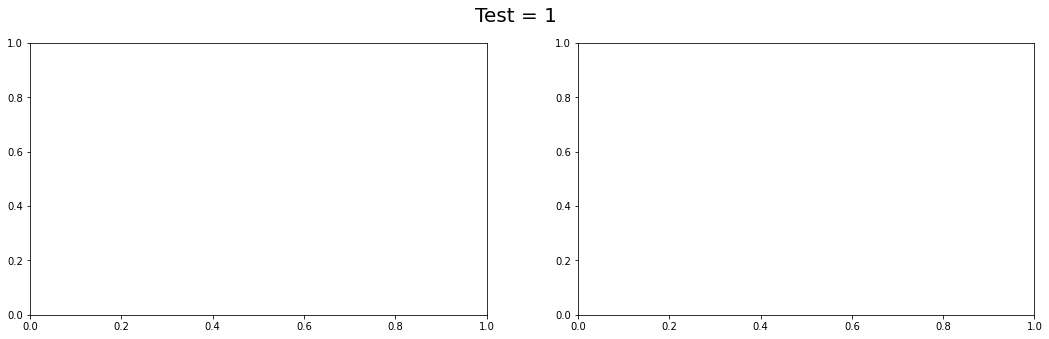

In [157]:
import os
import matplotlib.pyplot as plt
import csv
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/discrete/binary/test_potential/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = np.arange(-10,21,1)

#to make sure the lowest chain strength return results
#unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]

energies_all = []
std_all = []
min_max_all = []

with open(directory_main+'potential_range.csv', newline='') as f:
    reader = csv.reader(f)
    potential_range_tmp = list(reader)[0]
    potential_range = [float(x) for x in potential_range_tmp]

for i,vac in enumerate([1]):    
    directory = os.path.join(directory_main,sub_directory[i])
    directory = directory_main
    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('Test = %s'%vac, fontsize=20)
    
    total_multiplicity = []
    
    for j,potential in enumerate(potential_range):
        '''directory = os.path.join(directory_main,sub_directory[i])
        directory = directory_main
        fig, axs = plt.subplots(1,1,figsize=(10, 5), sharey=False)
        fig.suptitle('Test = %s'%vac, fontsize=20)'''
        #print(j)
        ratio_structures = []
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_i%s_'%j in f:
                df, param,Q = load_json(f,return_param = True, return_qubo = True)
                ############################CLASSICAL#############################

                energies, std, min_max = qubo_binary_energy_analysis(Q)
                energies_all.append(energies)
                std_all.append(std)
                min_max_all.append(min_max)
                    #energies_all = np.array(energies_all)
                    #std_all = np.array(std_all)
                    #min_max_all = np.array(min_max_all)

                ########################################################################
                total_reads = np.sum(df['num_occurrences'].to_numpy())
                sum_vector = np.sum(df.iloc[:,0:18],axis=1)
                multiplicity = df['num_occurrences'].to_numpy()
                total_multiplicity.append(np.sum(multiplicity))
                
                for k in range(0,18):
                    ratio_structures.append((np.sum(multiplicity[np.where(sum_vector == k)])/total_reads)*100)
        #print(ratio_structures)
        axs[0].plot(np.arange(1,19),ratio_structures,'-o',label=potential)#label=potential)
    axs[0].set_xticks(np.arange(1,19))
    axs[0].legend()
    axs[1].plot(potential_range,total_multiplicity,'-o')
    #axs[1].plot(potential_range,theta_range,'-o')
    plt.show
    

NameError: name 'energies_all' is not defined

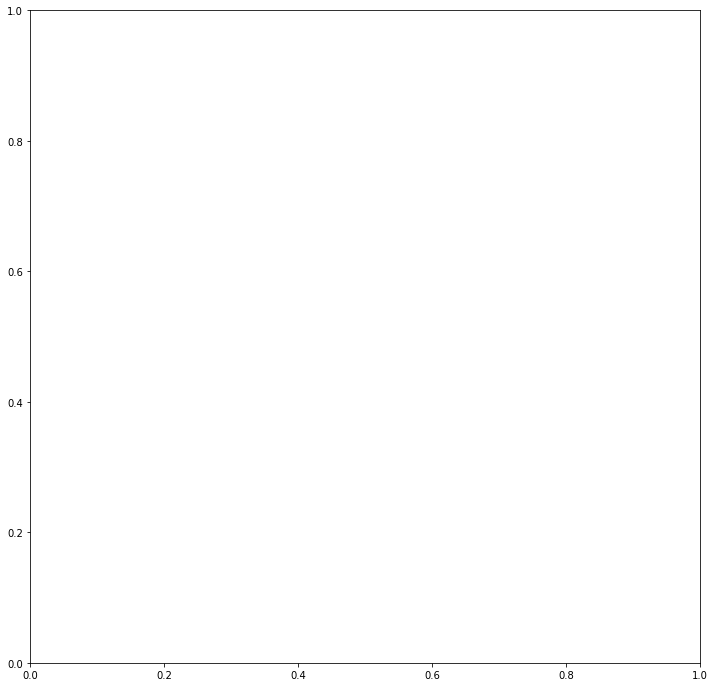

In [47]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1,figsize=(12, 12), sharey=False)
x = range(0,19)
for i,potential in enumerate(potential_range_1):
    y = energies_all[i]
    print(np.argsort(y))
    #err = std_all[i]
    err = min_max_all[i]
    ##print(err)
    axs.errorbar(x,y,yerr=err/2,fmt='-o',capsize=5,label=potential)
axs.set_xlabel('N C atoms',fontsize=18)
axs.set_ylabel('Energy',fontsize=18)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend()

In [127]:
df, a, Q = load_json('./data/discrete/test_potential/test_scaled_all_pot/Ngraphene_C18_bqm_i4_t10_r1000_t0_1678181764.json')
convert_df_binary2atom_discrete(df,[6,7])

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,0.000000,-451.305066,45
1,6,6,6,6,6,7,6,6,6,6,...,6,6,6,6,6,6,6,0.000000,-445.829098,7
2,6,6,6,6,6,6,6,6,7,6,...,6,6,6,6,6,6,6,0.000000,-445.829098,7
3,6,6,6,6,6,6,6,6,6,6,...,6,6,7,6,6,6,6,0.000000,-445.829098,11
4,7,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,0.000000,-445.829098,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,6,6,6,6,6,6,6,6,6,6,...,6,6,7,7,6,6,6,0.027778,-440.353131,1
672,6,6,6,6,6,6,6,6,6,7,...,6,6,7,6,6,6,7,0.027778,-415.094767,1
674,6,6,7,6,7,6,6,6,6,7,...,6,7,7,7,7,7,7,0.000000,-397.901418,1
675,6,7,6,7,6,7,6,7,6,6,...,6,7,6,6,6,7,6,0.000000,-395.608199,1


# TEST THETA (OLD keep as reference)

[[ -1.           2.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         -15.35476539   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          -1.           2.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         -15.35476539   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          -1.
    2.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  -15.35476539   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.          -1.           2.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.         -15.35476539   0.       

[[-1.          2.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          9.04833577  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -1.          2.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          9.04833577  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.          2.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          9.04833577
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -1.          2.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          9.04833577  0.          0.        ]
 [ 0.          0.          0.          0.          0.   

[[-2.          4.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         10.91928885  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -2.          4.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         10.91928885  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -2.          4.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         10.91928885
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -2.          4.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         10.91928885  0.          0.        ]
 [ 0.          0.          0.          0.          0.   

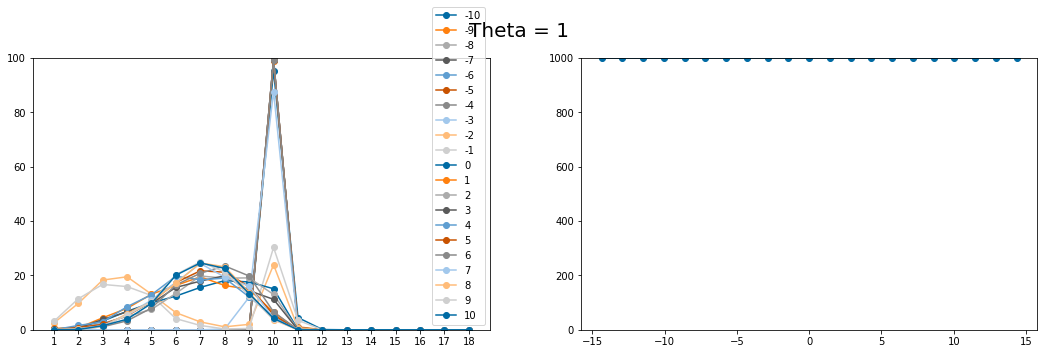

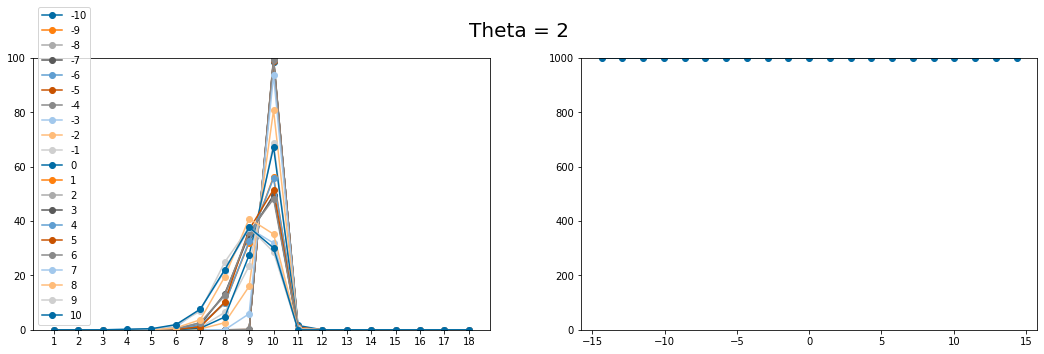

In [9]:
import os
import matplotlib.pyplot as plt
import csv
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/discrete/test_potential/test_tall_all_pot/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = np.arange(-10,21,1)

#to make sure the lowest chain strength return results
#unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]

with open(directory_main+'potential_range.csv', newline='') as f:
    reader = csv.reader(f)
    potential_range_tmp = list(reader)[0]
    potential_range = [float(x) for x in potential_range_tmp]

#for i,theta in enumerate([1,2,5,10,20,50,100,1000]):  
for i,theta in enumerate([1,2]):   
    #directory = os.path.join(directory_main,sub_directory[i])
    directory = directory_main
    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('Theta = %s'%theta, fontsize=20)
    
    total_multiplicity = []
    
    for j,potential in enumerate(potential_range):

        ratio_structures = []
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_i%s_'%j in f and '_t%s_'%theta in f:
                #print(f)
                df, param, Q = load_json(f,return_param = True, return_qubo = True)
                total_reads = np.sum(df['num_occurrences'].to_numpy())
                df = convert_discrete_df(df,2,[6,7])
                print(np.reshape(Q,(36,36))[0:10,0:10])
                sum_vector = np.sum(df.iloc[:,0:18],axis=1)
                multiplicity = df['num_occurrences'].to_numpy()
                total_multiplicity.append(np.sum(multiplicity))
                
                for k in range(0,18):
                    ratio_structures.append((np.sum(multiplicity[np.where(sum_vector == k)])/total_reads)*100)
        #print(ratio_structures)
        axs[0].plot(np.arange(1,19),ratio_structures,'-o',label=x[j])#label=potential)
    axs[0].set_xticks(np.arange(1,19))
    axs[0].set_ylim([0,100])
    axs[1].set_ylim([0,1000])
    axs[0].legend()
    axs[1].plot(potential_range,total_multiplicity,'-o')
    #axs[1].plot(potential_range,theta_range,'-o')
    plt.show
    

In [159]:
import os
import matplotlib.pyplot as plt
import csv
from quantum_computing_postprocessing import convert_discrete_df
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/discrete/test_potential/test_tall_all_pot/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = np.arange(-10,21,1)

#to make sure the lowest chain strength return results
#unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]

with open(directory_main+'potential_range.csv', newline='') as f:
    reader = csv.reader(f)
    potential_range_tmp = list(reader)[0]
    potential_range = [float(x) for x in potential_range_tmp]

for i,theta in enumerate([1,2,5,10,20,50,100,1000]):    
    #directory = os.path.join(directory_main,sub_directory[i])
    directory = directory_main
    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('Theta = %s'%theta, fontsize=20)
    
    total_multiplicity = []
    
    for j,potential in enumerate(potential_range):

        ratio_structures = []
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_i%s_'%j in f and '_t%s_'%theta in f:
                #print(f)
                df, param = load_json(f,return_param = True, return_qubo = False)
                total_reads = np.sum(df['num_occurrences'].to_numpy())
                df = convert_discrete_df(df,2)
                sum_vector = np.sum(df.iloc[:,0:18],axis=1)
                multiplicity = df['num_occurrences'].to_numpy()
                total_multiplicity.append(np.sum(multiplicity))
                
                for k in range(0,18):
                    ratio_structures.append((np.sum(multiplicity[np.where(sum_vector == k)])/total_reads)*100)
        #print(ratio_structures)
        axs[0].plot(np.arange(1,19),ratio_structures,'-o',label=x[j])#label=potential)
    axs[0].set_xticks(np.arange(1,19))
    axs[0].set_ylim([0,100])
    axs[1].set_ylim([0,1000])
    axs[0].legend()
    axs[1].plot(potential_range,total_multiplicity,'-o')
    #axs[1].plot(potential_range,theta_range,'-o')
    plt.show
    

ImportError: cannot import name 'convert_discrete_df' from 'quantum_computing_postprocessing' (/Users/brunocamino/Desktop/UCL/quantum_computing/quantum_computing_postprocessing.py)

In [67]:
ratio_structures

[]

In [44]:
ddf = load_json('./data/discrete/test_potential/test_t10_0/Ngraphene_C18_bqm_i0_t10_r1000_t0_1677761315.json')[0]
df = convert_discrete_df(ddf,2)
np.unique(np.sum(df.iloc[:,0:18].to_numpy(),axis=1),return_counts=True)
twelve = np.where(np.sum(df.iloc[:,0:18].to_numpy(),axis=1) == 12)
np.unique(df.iloc[twelve]['energy'])

array([-248.00074472, -246.97075937, -245.94077403, -244.91078868,
       -243.88080333, -233.81682229, -232.75554639, -228.32520964,
       -227.31086957])

In [75]:
Q

array([[-2.382,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , -2.382,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -2.382, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ..., -2.382,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   , -2.382,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   , -2.382]])

In [29]:
np.unique(np.round(df['energy'],4))

array([-248.2354, -248.1885, -248.1416, -248.0946, -248.0477, -248.0007,
       -247.9538, -247.1116, -247.0646, -247.0177, -246.9708, -246.9238,
       -246.0346, -245.9877, -245.9408, -245.8938, -245.8469, -245.8   ,
       -245.0047, -244.9577, -244.9108, -244.8639, -244.8169, -244.77  ,
       -243.8808, -243.8339, -243.7869, -243.74  , -242.8039, -242.7569,
       -242.71  , -242.6631, -241.7739, -241.727 , -241.68  , -241.6331,
       -240.697 , -240.65  , -240.6031, -240.5562, -239.6201, -239.5731,
       -239.5262, -238.5901, -238.5431, -238.4962, -237.5131, -237.4662,
       -237.4193, -236.4832, -236.3893, -235.3593, -234.7842, -234.3293,
       -234.2824, -233.8168, -233.7542, -232.7555, -232.7399, -232.7086,
       -232.646 , -232.2224, -231.6943, -231.6004, -231.4777, -231.1455,
       -230.633 , -230.6173, -230.5861, -230.5391, -229.5561, -229.5248,
       -228.5574, -228.5417, -228.3252, -228.247 , -227.4961, -227.3109,
       -226.187 , -220.9432])

In [55]:
chem_potential=[0,-1]
theta= np.max(np.abs(np.array(chem_potential)))*2
q2 = build_qubo_discrete_constraints(graphene_supercell,[6,7],chem_potential=chem_potential, theta=theta) 
q2[0:2,0:2]

array([[-2.,  4.],
       [ 0., -3.]])

## Results analysis

# <a id='diamond'>Diamond</a>

In [191]:
diamond_gui = Crystal_gui().read_cry_gui('./data/crystal/diamond/diamond_conv.gui')
diamond = cry_gui2pmg(diamond_gui)
#diamond = SpacegroupAnalyzer(diamond).get_conventional_standard_structure()

diamond_supercell_gui = Crystal_gui().read_cry_gui('./data/crystal/diamond/diamond_conv_super.gui')
diamond_supercell = cry_gui2pmg(diamond_supercell_gui)
#diamond = SpacegroupAnalyzer(diamond).get_conventional_standard_structure()


'''n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
diamond_supercell = copy.deepcopy(diamond)
diamond_supercell.make_supercell(scaling_matrix)
diamond_supercell.num_sites'''


vview(diamond_supercell)
N_C = diamond_supercell.num_sites
N_C


64

### Diamond pure

In [192]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s.d12'%N_C)

#runcry('./data/crystal/graphene_%s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s.out'%N_C)
E_d = crystal_output.get_final_energy()

In [101]:
max_shell = 3
shells, n_atoms_shell = np.unique(np.round(diamond_supercell.distance_matrix[0],5),return_counts=True)
neighbours_sorted = np.argsort(diamond_supercell.distance_matrix[0])[1:]
n_atoms_shell[0] = 0
atoms_shell = []
for i in range(max_shell):
    begin = np.cumsum(n_atoms_shell)[i]
    end = np.cumsum(n_atoms_shell)[i+1]
    atoms_shell.append(neighbours_sorted[begin:end])

In [96]:
np.cumsum(n_atoms_shell)

array([ 0,  4, 16, 28, 31, 43, 55, 59, 62, 63])

In [136]:
folder = './data/crystal/diamond/interaction_energy/'
for shell in range(2):
    
    #print(atoms_shell[shell])
    
    structure = copy.deepcopy(diamond_supercell)
    structure.replace(0,7)
    neighbouring_atoms = np.argsort(structure.distance_matrix[0])[np.cumsum(n_atoms_shell)[shell]+1]
    print(neighbouring_atoms)
    structure.replace(neighbouring_atoms,7)
    a = SpacegroupAnalyzer(structure).get_symmetrized_structure()

    eq_positions = []
    eq_sites = []
    for j,k in enumerate(a.equivalent_indices):
        for i in atoms_shell[shell]:
            if i in k:
                #print(i,j)
                eq_sites.append(i)
                eq_positions.append(j)
    
    structure.replace(0,6)

    for n,m in enumerate(np.unique(eq_positions,return_index=True)[1][1:]):
        structure = copy.deepcopy(diamond_supercell)
        structure.replace(eq_sites[0],7)
        structure.replace(eq_sites[m],7) 
        #print(structure.distance_matrix[0][eq_sites[m]])
        structure_gui = cry_pmg2gui(structure)
        structure_gui.write_crystal_gui(folder+'diamond_%s_s%s_%s_%s.gui'%(str(N_C),str(shell+2),str(n),str(eq_positions[m])))
        
        print('diamond_%s_s%s_%s_%s.d12'%(str(N_C),str(shell+2),str(n),str(eq_positions[m])))

13
diamond_64_s2_0_5.d12
19
diamond_64_s3_0_1.d12
diamond_64_s3_1_2.d12
diamond_64_s3_2_10.d12
diamond_64_s3_3_11.d12
diamond_64_s3_4_13.d12
diamond_64_s3_5_14.d12


### Diamond 1 N

In [197]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_1N.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_1N.d12'%N_C)

#runcry('./data/crystal/graphene_%s_1N'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_1N.out'%N_C)
E_d1N = crystal_output.get_final_energy()



EXITING: a .out file needs to be specified


AssertionError: 

### Diamond 2 N max dist

In [198]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[-1]
print(non_neighbouring_atoms)
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_2N.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_2N.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N.out'%N_C)
E_d2N = crystal_output.get_final_energy()



7
EXITING: a .out file needs to be specified


AssertionError: 

In [7]:
vview(structure)

### Diamond 2 N 2nd shell

In [199]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[5]
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_2N2s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_2N2s.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N2s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N2s.out'%N_C)
E_d2N2s = crystal_output.get_final_energy()


EXITING: a .out file needs to be specified


AssertionError: 

In [105]:
vview(structure)

### Diamond 2 N 3rd shell

In [106]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[11]
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_2N3s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_2N3s.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N2s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N3s.out'%N_C)
E_d2N3s = crystal_output.get_final_energy()


### Diamond 2 N neighbours

In [200]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)
neighbouring_atoms = np.argsort(structure.distance_matrix[0])[1]
structure.replace(neighbouring_atoms,7)


crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_2Nn.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_2Nn.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2Nn'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2Nn.out'%N_C)
E_d2Nn = crystal_output.get_final_energy()



EXITING: a .out file needs to be specified


AssertionError: 

### Diamond all 2N configurations

In [188]:
new_atom = 'N'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/diamond/diamond_confcount_2.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/diamond/diamond_confcount_2.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_d_2 = []
C_atoms = []
N_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_d_2.append(new_structure)
    N_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    C_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

In [198]:
#Write files
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,structure in enumerate(structures_d_2):
    crystal_gui = cry_pmg2gui(structure)
    crystal_gui.write_crystal_gui('./data/crystal/diamond/2N/diamond_%s_2N_%s.gui'%(str(N_C),str(i)))
    sh.copy('./data/crystal/diamond/diamond.d12','./data/crystal/diamond/2N/diamond_%s_2N_%s.d12'%(str(N_C),str(i)))
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm diamond_%s_2N_%s\n'%(str(N_C),str(i)))
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys diamond_%s_2N_%s'%(str(N_C),str(i)))
    data.append('\n\n')
    
with open('./data/crystal/diamond/2N/diamond_64_2N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)

### Diamond all 3N configurations

In [201]:
new_atom = 'N'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/diamond/diamond_confcount_3.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/diamond/diamond_confcount_3.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_d_3 = []
C_atoms = []
N_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_d_3.append(new_structure)
    N_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    C_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

In [203]:
#Write files
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,structure in enumerate(structures_d_3):
    crystal_gui = cry_pmg2gui(structure)
    crystal_gui.write_crystal_gui('./data/crystal/diamond/3N/diamond_%s_3N_%s.gui'%(str(N_C),str(i)))
    sh.copy('./data/crystal/diamond/diamond.d12','./data/crystal/diamond/3N/diamond_%s_3N_%s.d12'%(str(N_C),str(i)))
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm diamond_%s_3N_%s\n'%(str(N_C),str(i)))
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys diamond_%s_3N_%s'%(str(N_C),str(i)))
    data.append('\n\n')
    
with open('./data/crystal/diamond/3N/diamond_64_3N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)

In [205]:
N_C

64

# <a id='dqm'>DQM</a>

In [31]:
parameters[0]

[0.374200641927153, 0.3898459172511745, 1.435476538932562]

In [86]:
def build_discrete_quadratic_model_test(structure,species, parameters, concentration = None, 
                                        potential = None,max_neigh = 1,):
    # structure = pymatgen Structure object
    # species = list of atomic numbers
    # interaction = interactomic potential given as a matrix element by row
    # concentrations = list of concentrations
    
    # https://github.com/dwave-examples/graph-partitioning
    
    from dimod import DiscreteQuadraticModel
    
    c = np.arange(structure.num_sites)    
    adjacency_matrix = build_adjacency_matrix(structure)    
    dqm = DiscreteQuadraticModel()     
    n_species = len(species)
    #concentration_1 = concentrations[0]
    
    #n_atoms_species = [int(np.rint(x*structure.num_sites)) for x in concentrations[:-1]]
    #n_atoms_species.append(int(np.rint(structure.num_sites-np.sum(c))))
   
    #Make this better (or input?)
    interaction_dict = {}
    index = -1
    for i in range(len(species)):
        for j in range(i,len(species)):
            index += 1
            interaction_dict[(i, j)] = parameters[index]
    
    #This creates a (num_sites*num_species) x (num_sites*num_species) matrix
    #DOES IT INCLUDE THE ONE-HOT ENCODING?
    
    for i in range(structure.num_sites):
        dqm.add_variable(n_species, label=i)
    
    #define linked atoms and bond strength
    for i in range(structure.num_sites):
        if potential != None:
            dqm.set_linear(i, potential)
        for j in np.where(adjacency_matrix[i] == 1)[0]:
            #dqm.set_quadratic(i, j, {(0, 0): cu_cu, (0, 1): cu_zn, (1, 1): zn_zn})
            dqm.set_quadratic(i, j, interaction_dict)
    
    # This imposes a double constraint (on both species)
    if concentration != None:
        for i,conc in enumerate(concentration):
            concentration_1_v = [(s,i,1) for s in c] #make loop

            #Define the concentration as a constraint
            dqm.add_linear_equality_constraint(
                        concentration_1_v,
                lagrange_multiplier=10.,
                        constant= -conc)
    
    
    return dqm

#dqm = build_discrete_quadratic_model_test(graphene_supercell,[6,7], parameters=parameters[0], potential=[0,-1], max_neigh = 1)
#dqm = build_discrete_quadratic_model_test(graphene_supercell,[6,7], parameters=parameters[0], concentration=[15,3], max_neigh = 1)



In [87]:
from dwave.system import LeapHybridDQMSampler

sampleset = LeapHybridDQMSampler().sample_dqm(dqm,
                label='Test graphene') 


In [88]:
np.unique(np.round(sampleset.to_pandas_dataframe()['energy'].to_numpy(),5))


array([10.24422, 11.27421])

In [89]:
sampleset.to_pandas_dataframe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,energy,num_occurrences
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,10.244225,1
1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,11.274210,1
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10.244225,1
3,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,10.244225,1
4,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,10.244225,1
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,10.244225,1
6,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,11.274210,1
7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,11.274210,1
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,10.244225,1
9,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.244225,1


In [90]:
vview(graphene_supercell)

In [7]:
def build_interaction_matrix_test(structure, species, parameters, alpha=1, atomic_contribution=None, max_neigh = 1):
    
    #returns an N_sites x N_sites matrix where the i,j element represent the interaction between i and j
    #parameters is a list of list where the 
        # first row represents the first neightbour interaction 
        # second row represents the second neightbour interaction and so on

        #Within the same row, the k-element represent the interaction between species i+j
        #(Think of it as an upper triangular matrix)
        

    num_sites = structure.num_sites
    num_species = len(species)
    num_elements = num_sites*num_species

    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    #distance_matrix_filter
    
    interaction_matrix = np.zeros((num_elements,num_elements))
    
    #loop 
    if atomic_contribution != None:
        for i in range(num_species):
            interaction_matrix[np.arange(i,num_sites*num_species,num_species),np.arange(i,num_sites*num_species,num_species)] = atomic_contribution[i]
    
    
    parameters = np.array(parameters)
    for i in range(num_sites):
        for j in range(i,num_sites):
            g = distance_matrix_filter[i,j]
            if g > 0:
                for k in range(num_species):
                    #for l in range(k,num_species): for upper diagonal
                    for l in range(num_species):
                        param = alpha*parameters[g-1][k+l] #the k+l sum is uniquely defining the pair potential
                        interaction_matrix[i*num_species+k,j*num_species+l] = param
                        #interaction_matrix[i*num_species-k,j*num_species+l] = param
                
    return interaction_matrix

species=[6,7]
#parameters = [[E_CC,E_CN,E_NN]]
#build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)
#build_interaction_matrix_test(structure, species, parameters, alpha=1, atomic_contribution=[1,2], max_neigh = 1)
build_interaction_matrix_test(structure, species, [[E_CC,E_CN,E_NN]],  alpha=1, max_neigh = 1)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.38984592, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [285]:
np.arange(1,36,2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35])

In [56]:
def build_discrete_vector(x,num_species=None):
    x = np.array(x)
    unique_species = np.unique(x)

    if num_species == None:
        num_species = len(unique_species)
        
    x_binary = np.array([0]*len(x)*num_species)
    
    for i,atom in enumerate(unique_species):
        position = np.where(x == atom)[0]
        x_binary[position*num_species+i] = 1

    return x_binary
#build_discrete_vector([6,7,6,7,8])

In [9]:
def find_distances(dataframe, structure, atom_type):
    
    num_sites = structure.num_sites
    
    all_config = dataframe.iloc[:,0:num_sites].to_numpy()
    
    for config in all_config:
        structure_2 = copy.deepcopy(structure)
        for k,m in enumerate(config):
            structure_2.replace(k,int(m))
        atom_pos = np.where(np.array(structure_2.atomic_numbers) == atom_type)[0]
        for i in range(len(atom_pos)):
            for j in range(i+1,len(atom_pos)):
                print(structure_2.distance_matrix[atom_pos[i],atom_pos[j]])
#find_distances(df1,structure,7)            

In [10]:
def find_symmetry_equivalent_structures_discrete(structure, dataframe):
    
    from pymatgen.analysis.structure_matcher import StructureMatcher 
    import copy 

    df = dataframe

    '''if vacancies is not None and type(vacancies) is int:
        num_atoms = sum([x.isdigit() for x in df.columns]) 
        all_config = df.iloc[:,0:num_atoms].to_numpy()
        sum_vector = np.sum(all_config,axis=1)
        feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]
        df = df.iloc[feasible_config,:]'''


    
    num_sites = structure.num_sites
    configurations = df.iloc[:,0:num_sites].to_numpy()
    
    multiplicity = dataframe['num_occurrences'].to_numpy()
    chain_break = dataframe['chain_break_fraction'].to_numpy()
    energies = dataframe['energy'].to_numpy()
    
    all_structures = []
    for config in configurations:
        structure_2 = copy.deepcopy(structure)
        for i,j in enumerate(config):
            structure_2.replace(i,j)
        all_structures.append(structure_2)
    
    #Find the unique structures
    unique_structures = StructureMatcher().group_structures(all_structures)
    return unique_structures
    unique_structures_label = []
    
    #Find to which class the structures belong to
    for structure in all_structures:
        for i in range(len(unique_structures)):
            #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
            if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
                unique_structures_label.append(i)
                break
    print(unique_structures_label)
    unique_structures_label = np.array(unique_structures_label)
    unique_multiplicity = []
    unique_chain_break = []
    for x in range(len(unique_structures)):
        multiplicity_tmp = multiplicity[np.where(unique_structures_label==x)[0]]
        unique_multiplicity.append(np.sum(multiplicity_tmp))
        unique_chain_break.append(np.average(chain_break[np.where(unique_structures_label==x)[0]],weights=multiplicity_tmp))
    
    df = df.iloc[np.unique(unique_structures_label,return_index=True)[1]]
    
    if len(df) == len(unique_multiplicity):
        df1 = df.copy(deep=True)
        df1['num_occurrences'] = unique_multiplicity
        df1['chain_break_fraction'] = unique_chain_break
        
        return df1
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None

In [11]:
def display_structures(structure, dataframe, index, discrete=False):
    
    #structure = pymatgen structure object
    #dataframe = sampleset.to_pandas_dataframe()
    #index = list of indices of structures to visualise

    from pymatgen.io.ase import AseAtomsAdaptor
    from ase.visualize import view
    import copy

    num_atoms = structure.num_sites
    
    if discrete == True:
        for i in index:
            structure_2 = copy.deepcopy(structure)
            df_tmp =  dataframe.loc[[i]]
            for k,j in enumerate(df_tmp.iloc[0,0:num_atoms].to_numpy()):
                structure_2.replace(k,int(j))
            view(AseAtomsAdaptor().get_atoms(structure_2))
    elif discrete == False:
        for i in index:
            structure_2 = copy.deepcopy(structure)
            for j in np.where(dataframe.iloc[i,0:num_atoms] == 0)[0]:
                structure_2.replace(j,1)
            
            view(AseAtomsAdaptor().get_atoms(structure_2))

# <a id='optgeom'>Graphene geometry optimisation</a>

In [45]:
from CRYSTALpytools.execute import runcry
crystal_input = Crystal_input().from_file('./data/crystal/convergence/basis_set/graphene_VTZ_sp.d12')
#for i in range(1,10):
for i in [0]:
    a = np.round(2.4466805+((i*0.00001)),8)
    print(a)
    crystal_input.geom_block[2] = '%s\n'%a
    crystal_input.write_crystal_input('./data/crystal/convergence/basis_set/manual_opt/graphene_VTZ_sp_%s.d12'%i)
    runcry('./data/crystal/convergence/basis_set/manual_opt/graphene_VTZ_sp_%s'%i)
    crystal_output = Crystal_output().read_cry_output('./data/crystal/convergence/basis_set/manual_opt/graphene_VTZ_sp_%s.out'%i)
    print(i,a,crystal_output.get_final_energy())

2.4466805
0 2.4466805 -2072.6318826563615


In [ ]:
-3  2.44495025  -2072.631239372633
-2  2.44543953  -2072.631818666773
-1  2.44592882  -2072.631863753537
-1  2.44641807  -2072.6318736859107
0   2.4464181   -2072.63187368621 

    2.44661381  -2072.631874874776
    2.44663     -2072.631875698764
    2.44664     -2072.631875701975
    2.44665     -2072.63187630302
0.1 2.44666274  -2072.6318825941835
    2.44667     -2072.6318825968774
    2.44668     -2072.6318826565794
    2.4466805   -2072.6318826563615
    2.446681    -2072.631882655872
    2.446683    -2072.6318826521983
    2.446685    -2072.631882644497
    2.44669     -2072.6318826380484
    
    
    
0.2 2.44690738  -2072.631871284642
    2.44690741  -2072.6318712842335
1   2.44690738   -2072.631871284642

In [65]:
a = cry_gui2pmg(Crystal_gui().read_cry_gui('./data/crystal/diamond/diamond_pob_TZVP.gui'))

In [66]:
view(AseAtomsAdaptor().get_atoms(a))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [63]:
np.argsort(a.distance_matrix[4])

array([ 4, 16, 21, 20,  0,  3,  7,  5,  8,  9, 19, 17, 25, 23, 22, 28, 31,
       24, 26,  2,  1, 15, 13, 11, 10, 14, 12,  6, 29, 30, 18, 27])

In [62]:
np.sort(a.distance_matrix[4])

array([0.        , 1.42605516, 1.42605516, 1.42605516, 2.47      ,
       2.47      , 2.47      , 2.47      , 2.47      , 2.47      ,
       2.85211033, 2.85211033, 2.85211033, 3.77298732, 3.77298732,
       3.77298732, 3.77298732, 3.77298732, 3.77298732, 4.27816549,
       4.27816549, 4.27816549, 4.27816549, 4.27816549, 4.27816549,
       4.94      , 4.94      , 4.94      , 5.14171502, 5.14171502,
       5.14171502, 5.70422066])

# <a id=''>Graphene bands</a>

In [48]:
from CRYSTALpytools.crystal_io import Properties_input

#Create the bands input object
bands_input = Properties_input()
#Add the newk block to the input object
bands_input.make_newk_block(12,24)

#Prepare the band_block
k_path = [[0,0,0],[0.5,0,0],[1/3,1/3,0.0],[0,0,0]]
n_kpoints = 200
first_band = 1
last_band = 26
bands_input.make_bands_block(k_path,n_kpoints,first_band,last_band)

#Write the input
#bands_input.write_properties_input('data/bands_input_1.d3')

In [53]:
bands_input.property_block

['BAND\n',
 'BAND STRUCTURE CALCULATION\n',
 '3 10000 200 1 26 1 0\n',
 '0 0 0  5000 0 0\n',
 '5000 0 0  3333 3333 0\n',
 '3333 3333 0  0 0 0\n',
 'END\n']

In [70]:
from pymatgen.symmetry.bandstructure import HighSymmKpath
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

from CRYSTALpytools.crystal_io import Crystal_output
from CRYSTALpytools.crystal_io import Properties_input
from CRYSTALpytools.convert import cry_out2pmg


#Create the bands input object
bands_input = Properties_input()
#Add the newk block to the input object
bands_input.make_newk_block(12,24)

#Read the structure
#mgo = Crystal_output().read_cry_output('data/mgo.out')
#mgo = cry_out2pmg(mgo)
#mgo_prim = SpacegroupAnalyzer(mgo).get_primitive_standard_structure(international_monoclinic=False)

#Obtain the k path object
k_path = HighSymmKpath(a)

n_kpoints = 500
first_band = 1
last_band = 26
bands_input.make_bands_block(k_path,n_kpoints,first_band,last_band)

#Write the input
bands_input.write_properties_input('data/crystal/diamond/diamond_pob_TZVP.d3')

In [68]:
bands_input.property_block

['BAND\n',
 'BAND STRUCTURE CALCULATION\n',
 '11 8 200 1 26 1 0\n',
 '0 0 0  4 0 4\n',
 '4 0 4  4 2 5\n',
 '4 2 5  2 2 5\n',
 '2 2 5  0 0 0\n',
 '0 0 0  4 4 4\n',
 '4 4 4  5 2 5\n',
 '5 2 5  4 2 5\n',
 '4 2 5  4 4 4\n',
 '4 4 4  2 2 5\n',
 '2 2 5  5 2 5\n',
 '5 2 5  4 0 4\n',
 'END\n']

# <a id='descriptor'>The descriptor</a>

In [390]:
# THIS IS BEAUTIFULLY IT
#def build_descriptor(structures,max_radius=5):
structure = structures[0]
the_descriptor = []

max_radius = 3

for i in range(structure.num_sites):

    site_distance = []
    unit_cell_neighbour = []
    centered_cart_coords = []

    for site in structure.get_all_neighbors(max_radius,sites=[structure.sites[i]])[0]:

        site_distance.append(site.distance(structure.sites[i]))
        centered_cart_coords.append(site.coords-structure.cart_coords[i])


        for j,site2 in enumerate(structure.sites):
            if site.is_periodic_image(site2) == True:
                unit_cell_neighbour.append(j)
    unit_cell_neighbour = np.array(unit_cell_neighbour)

    centered_sph_coords = cart2sph_array(centered_cart_coords)

    spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,0]*100+\
                                      np.array(centered_sph_coords)[:,1]*10 +\
                                      np.array(centered_sph_coords)[:,2])

    the_descriptor.append(unit_cell_neighbour[spatial_distribution])
the_descriptor = np.array(the_descriptor)
#print(the_descriptor)
'''for k in unit_cell_neighbour[spatial_distribution]:
    print(np.round(structure.distance_matrix[0][k],4),
          np.round(structure.cart_coords[k]-structure.cart_coords[0],4))'''
descriptor_sorted = []
descriptor_non_sorted = []
descriptor_atom_number = []

for structure in structures:
    descriptor_sorted.append(np.array(structure.atomic_numbers)[the_descriptor][np.argsort(structure.atomic_numbers),:])
    descriptor_non_sorted.append(np.array(structure.atomic_numbers)[the_descriptor])

    descriptor_atom_number.append(np.c_[structure.atomic_numbers,np.array(structure.atomic_numbers)[the_descriptor][np.argsort(structure.atomic_numbers),:]])
descriptor_sorted = np.array(descriptor_sorted)   
descriptor_non_sorted = np.array(descriptor_non_sorted)   
descriptor_atom_number = np.array(descriptor_atom_number)

neighbours_spatial_dist_all = copy.deepcopy(descriptor_atom_number)

# OLD

## Generate structures

### Graphene 1 N

In [82]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene/graphene_%s_1N.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene/graphene_%s_1N.d12'%N_C)

#runcry('./data/crystal/graphene_%s_1N'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/graphene_%s_1N.out'%N_C)
E_g1N = crystal_output.get_final_energy()
#E_graphene_1N_atom = E_graphene_1N/graphene_supercell.num_sites


EXITING: a .out file needs to be specified


AssertionError: 

### Graphene 2 N max dist

In [85]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[-1]
print(non_neighbouring_atoms)
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene/graphene_%s_2N.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene/graphene_%s_2N.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene/graphene_%s_2N.out'%N_C)
E_g2N = crystal_output.get_final_energy()



5
EXITING: a .out file needs to be specified


AssertionError: 

## Convergence on cell size

In [603]:
import copy
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites

18

In [604]:
view(AseAtomsAdaptor().get_atoms(structure))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [3]:
shells, atom_index = np.unique(np.round(structure.distance_matrix[0],5),return_index=True)
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')
slurm_file_crystal = './data/crystal/slurm_file_crystal.slurm'

file = open(slurm_file_crystal, 'r')
slurm_file_crystal_data = file.readlines()
file.close()

file_names = []

for i,atom in enumerate(atom_index[1:]):
    structure = copy.deepcopy(graphene_supercell)
    structure.replace(0,7)
    #print(structure.distance_matrix[0,atom])
    structure.replace(atom,7)
    crystal_gui = cry_pmg2gui(structure,dimensionality=2)
    crystal_gui.write_crystal_gui('./data/crystal/convergence/graphene_200_%ss.gui'%str(i+1))
    crystal_input.write_crystal_input('./data/crystal/convergence/graphene_200_%ss.d12'%str(i+1))
    
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_200_%ss &\n'%str(i+1))
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_200_%ss &\n'%str(i+1))
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')
    file_names.append('graphene_200_%ss'%str(i+1))

#with open('./data/crystal/convergence/graphene_200.slurm', 'w') as file:
    #for line in slurm_file_crystal_data:
        #file.writelines(line)

In [5]:
folder = './data/crystal/convergence/200_atoms/'

In [35]:
scf_energy = []
scf_energy_dict = {}
distance = []

for file in file_names:
    file_name = folder+file
    crystal_output = Crystal_output().read_cry_output(file_name)
    crystal_gui = Crystal_gui().read_cry_gui(file_name)
    #view(AseAtomsAdaptor().get_atoms(cry_gui2pmg(crystal_gui)))
    atom_1 = np.where(np.array(cry_gui2pmg(crystal_gui).atomic_numbers) == 7)[0][0]
    atom_2 = np.where(np.array(cry_gui2pmg(crystal_gui).atomic_numbers) == 7)[0][1]
    distance.append(cry_gui2pmg(crystal_gui).distance_matrix[atom_1][atom_2])
    scf_energy.append(crystal_output.get_final_energy())
    scf_energy_dict[file] = [crystal_output.get_final_energy()]
pd.DataFrame.from_dict(scf_energy_dict).transpose()

scf_energy_arr = np.array(scf_energy)

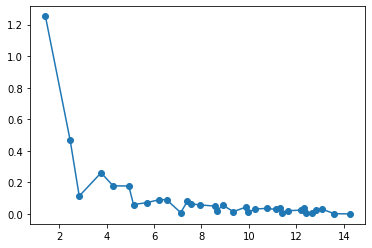

In [36]:
import matplotlib.pyplot as plt

x = np.arange(1,35)
y=scf_energy_arr[:] - scf_energy_arr[-1]

plt.plot(distance,y,'-o')

# COHP

In [37]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_cohp_dat.cohp')

In [38]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_18_1N_cohp_dat.cohp')

In [39]:
def int_cohp(cohp):
    
    cohp_data = []
    for line in cohp.data[4:-1]:
        new_line = [ float(x.strip('\n')) for x in re.split(' +', line.lstrip())]
        cohp_data.append(new_line)
    cohp_data = np.array(cohp_data)
    cohp_data[:,0] = cohp_data[:,0]*27.2114
    min_energy = cohp_data[0,0]
    max_energy = cohp_data[-1,0]
    energy_step = (max_energy-min_energy)/cohp.n_energy
    bond_strength = [np.sum((cohp_data[:,0] < 0.)*cohp_data[:,i]*energy_step) for i in range(2,cohp.n_proj+1)]
    #print(np.sum((cohp_data[:,0] < 0.)*cohp_data[:,2]*cohp_data[:,0])/cohp.n_energy)
    print(bond_strength)
    return(bond_strength)
int_cohp(cohp)

[1962.4953185873721]


[1962.4953185873721]

In [188]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_18_1N_cohp_dat.cohp')
CN_bond_s = int_cohp(cohp)

[1962.4953185873721]


In [189]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_18_2N2s_cohp_dat.cohp')
CN_bond_s = int_cohp(cohp)

[1942.6300654220017]


In [190]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_18_3N2s_cohp_dat.cohp')
CN_bond_s = int_cohp(cohp)

[1902.5769318845519]


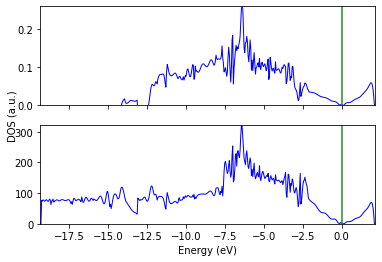

In [16]:
from plot import *
plot_cry_doss(cohp)

# Hybrid method

In [119]:
from dimod import DiscreteQuadraticModel

atom_types = [6,7]

# upper matrix
bond_energy = [E_cc_bond,E_cn_bond,E_nn_bond]

A = build_adjacency_matrix(graphene_supercell)

dqm = DiscreteQuadraticModel()

for atom in range(graphene_supercell.num_sites):
    dqm.add_variable(2, label=atom)
    

for i in range(graphene_supercell.num_sites):
    for j in range(i+1,graphene_supercell.num_sites):
        for k in range(len(atom_types)):
            for m in range(k,len(atom_types)):
                if A[i,j] == 1:
                    dqm.set_quadratic(i, j, {(k, m): bond_energy[k+m]})


                
test_q = build_qubo_matrix(dqm)
dqm.to_numpy_vectors()[0]


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_3379/3372389206.py:26: DeprecationWarning: `return_offset` will default to `True` in the future.
  dqm.to_numpy_vectors()[0]


array([ 0,  2,  4,  6,  8, 10, 12, 14], dtype=uint16)

# The functions

In [63]:
def build_qubo_binary_constraints(structure, concentration=None, chem_potential = None,
                                    lambda_1 = 2):
    """Summary line.

    Extended description of function.

    Args:
        structure (pymatgen Structure object): Description of arg1
        concentration (int): concentration of the species corresponding to |1>
        chem_potential (float): chemical potential of the species corresponding to |1>

    Returns:
        numpy.array: QUBO matrix containing the contraints only

    """
    
    if concentration is not None and chem_potential is not None:
        print('Please select either concentration or chemical potential')
        return None
    
    num_sites = structure.num_sites
    #num_species = len(species)
    num_elements = num_sites#*num_species
    
    
    Q = np.zeros((num_elements,num_elements))
    
    if concentration is not None and type(concentration) is int:
        
        for i in range(0,num_sites): #diag
            Q[i,i] = lambda_1*(1-2*concentration) 
            for j in range(i+1,num_sites):
                Q[i,j] = 2*lambda_1            
    
    elif chem_potential is not None and type(chem_potential) is float:
        np.fill_diagonal(Q,chem_potential)
        
            
    return Q
build_qubo_binary_constraints(structure, concentration=None, chem_potential = 0.2,
                                    lambda_1 = 1)

array([[0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ,

In [50]:
def build_qubo_binary_interaction(structure, parameters, alpha=1, atomic_contribution=None, max_neigh = None):
    
    #returns an N_sites x N_sites matrix where the i,j element represent the interaction between i and j
    #parameters is a list of list where the 
        # first row represents the first neightbour interaction 
        # second row represents the second neightbour interaction and so on

        #Within the same row, the k-element represent the interaction between species i+j
        #(Think of it as an upper triangular matrix)
        

    num_sites = structure.num_sites
    #num_species = len(species)
    num_elements = num_sites*2#*num_species
    
    if max_neigh == None:
        max_neigh = len(parameters)
        
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    interaction_matrix = np.zeros((num_elements,num_elements))
    
    #I DON'T THINK THIS IS NEEDED FOR THE BINARY 
    # if atomic_contribution != None:
    #    for i in range(num_species):
    #        interaction_matrix[np.arange(i,num_sites*num_species,num_species),np.arange(i,num_sites*num_species,num_species)] = atomic_contribution[i]
    
    parameters = np.array(parameters)
    diag_element = parameters[:,1]-parameters[:,0] # DeltaEcc/cn
    off_diag_element = (parameters[:,2]-parameters[:,1])-2*(parameters[:,1]-parameters[:,0]) #DeltaEnn/cc-2DeltaEcc/cn

    for i in range(num_sites):
        for j in range(0,num_sites):
            g = distance_matrix_filter[i,j]
            #print(i,j,g)
            if g > 0:
                interaction_matrix[i,i] += diag_element[g-1]
                interaction_matrix[j,j] += diag_element[g-1]
                interaction_matrix[i,j] += off_diag_element[g-1]
                
    return interaction_matrix

print(build_qubo_binary_interaction(structure=graphene_supercell, parameters=[[1,2,3],[0.5,1,1.5]], 
                                    alpha=1, atomic_contribution=None, max_neigh = 1)
    [0:18,0:18])


[[ 3.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  3.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  3.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  3.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0. -1. -1.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0. -1. -1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.

In [18]:
num_sites = graphene_supercell.num_sites

Q_interaction = build_qubo_binary_interaction(graphene_supercell,[[E_CC,E_CN,E_NN]])

energies_all = []
std_all = []
min_max_all = []

#chemical_potential_all = np.arange(1.4,1.6,0.02)
chemical_potential_all = np.arange(-5,-2.1,0.5)

#chemical_potential_all = np.arange(0,3,0.25)
#chemical_potential_all = [0]
for chemical_potential in chemical_potential_all:    
    Q_potential = build_qubo_binary_constraints(structure,chem_potential=float(chemical_potential))
    Q = (Q_interaction+Q_potential)
    #print(np.diag(Q))
    df_qubo = qubo_classical_solver(Q)
    num_atoms = np.sum(df_qubo.iloc[:,0:num_sites].to_numpy(),axis=1)

    energies = []
    std = []
    min_max = []
    for i in range(0,num_sites+1):
        structure_n = np.where(num_atoms == i)[0]
        energies_tmp = df_qubo.iloc[structure_n.tolist()]['Energy'].to_numpy()  
        #####display(df_qubo.iloc[structure_n.tolist()])

        energies.append(np.average(energies_tmp))
        std.append(np.std(energies_tmp))
        min_max.append(np.max(energies_tmp)-np.min(energies_tmp))

    energies_all.append(energies)
    std_all.append(std)
    min_max_all.append(min_max)

energies_all = np.array(energies_all)
std_all = np.array(std_all)
min_max_all = np.array(min_max_all)

energies_all_norm = energies_all       

In [6]:
def qubo_binary_energy_analysis(Q):
    
    energies_all = []
    std_all = []
    min_max_all = []

    num_sites = Q.shape[0]
    df_qubo = qubo_classical_solver(Q)
    num_atoms = np.sum(df_qubo.iloc[:,0:num_sites].to_numpy(),axis=1)

    energies = []
    std = []
    min_max = []
    for i in range(0,num_sites+1):
        structure_n = np.where(num_atoms == i)[0]
        energies_tmp = df_qubo.iloc[structure_n.tolist()]['Energy'].to_numpy()  
        #####display(df_qubo.iloc[structure_n.tolist()])

        energies.append(np.average(energies_tmp))
        std.append(np.std(energies_tmp))
        min_max.append(np.max(energies_tmp)-np.min(energies_tmp))

    return energies, std, min_max



[15 14 16 13 17 12 18 11 10  9  8  7  6  5  4  3  2  1  0]
[12 13 11 14 10 15  9 16  8 17  7 18  6  5  4  3  2  1  0]
[ 9 10  8 11  7 12  6 13  5 14  4 15  3 16  2 17  1 18  0]
[ 7  6  8  5  9  4 10  3 11  2 12  1 13  0 14 15 16 17 18]
[ 4  3  5  2  6  1  7  0  8  9 10 11 12 13 14 15 16 17 18]
[ 1  2  0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


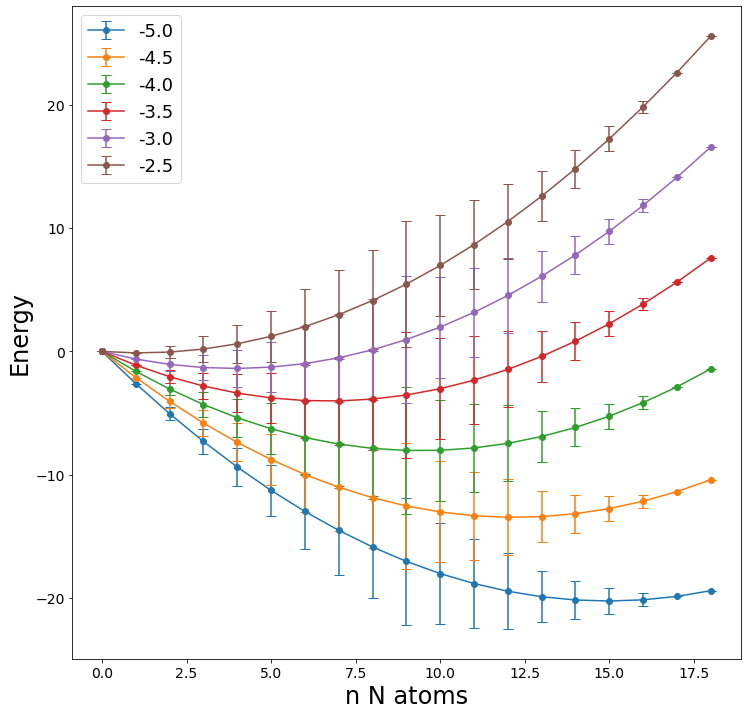

In [25]:
import matplotlib.pyplot as plt
num_sites = 18
fig, axs = plt.subplots(1,1,figsize=(12, 12), sharey=False)
x = range(0,num_sites+1)
for i,potential in enumerate(chemical_potential_all):
    y = energies_all[i]
    print(np.argsort(y))
    #err = std_all[i]
    err = min_max_all[i]
    ##print(err)
    axs.errorbar(x,y,yerr=err/2,fmt='-o',capsize=5,label=potential)
axs.set_xlabel('n N atoms',fontsize=24)
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)
fig.savefig('./data/chemical_potential/C_1_mu_all.jpg' ,dpi=200)

In [ ]:
no_spin/graphene_32_1N.out: *  OPT END - CONVERGED * E(AU):  -1.235213561380E+03  POINTS   12 *
spin/graphene_32_1N.out: *     OPT END - CONVERGED * E(AU):  -1.235211656964E+03  POINTS   25 *
levshift/graphene_32_1N.out: * OPT END - CONVERGED * E(AU):  -1.235209589614E+03  POINTS    4 *

# <a id='simple_qubo'>Simple QUBO</a>


In [463]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

#optimised cell
lattice = np.array([[  0.212090484210E+01, -0.122450498151E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.244900996303E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.000000000000E+00,  0.500000000000E+03]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_8 = copy.deepcopy(graphene)
graphene_8.make_supercell(scaling_matrix)

parameters = [[-5,-4.,-1.]]
#parameters = [[-1,-4.,-5.]]
# E_CC_g = -6.801
# E_CN_g = -6.007 
# E_NN_g = -4.187
# parameters = [[E_CC_g,E_CN_g,E_NN_g]]
Q = build_qubo_binary_interaction_test(graphene_8,parameters)
Q

array([[3., 0., 0., 0., 2., 2., 2., 0.],
       [0., 3., 0., 0., 2., 2., 0., 2.],
       [0., 0., 3., 0., 2., 0., 2., 2.],
       [0., 0., 0., 3., 0., 2., 2., 2.],
       [2., 2., 2., 0., 3., 0., 0., 0.],
       [2., 2., 0., 2., 0., 3., 0., 0.],
       [2., 0., 2., 2., 0., 0., 3., 0.],
       [0., 2., 2., 2., 0., 0., 0., 3.]])

In [425]:
qubo_classical_solver(adjust_qubo(Q, 1))

,0,1,2,3,Energy
0,0,0,0,0,0.0
1,0,0,0,1,0.0
2,0,0,1,0,0.0
3,0,0,1,1,0.0
4,0,1,0,0,0.0
5,0,1,0,1,4.0
6,0,1,1,0,4.0
7,0,1,1,1,8.0
8,1,0,0,0,0.0
9,1,0,0,1,4.0


In [291]:
def build_qubo_binary_interaction_test(structure, parameters, max_neigh = None):
    
    #returns an N_sites x N_sites matrix where the i,j element represent the interaction between i and j
    #parameters is a list of list where the 
        # first row represents the first neightbour interaction 
        # second row represents the second neightbour interaction and so on

        #Within the same row, the k-element represent the interaction between species i+j
        #(Think of it as an upper triangular matrix)
        

    num_sites = structure.num_sites
    #num_species = len(species)
    num_elements = num_sites#*num_species
    
    if max_neigh == None:
        max_neigh = len(parameters)
        
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    interaction_matrix = np.zeros((num_elements,num_elements))
    
    #I DON'T THINK THIS IS NEEDED FOR THE BINARY 
    # if atomic_contribution != None:
    #    for i in range(num_species):
    #        interaction_matrix[np.arange(i,num_sites*num_species,num_species),np.arange(i,num_sites*num_species,num_species)] = atomic_contribution[i]
    
    parameters = np.array(parameters)
    diag_element = parameters[:,1]-parameters[:,0] # DeltaEcc/cn
    off_diag_element = (parameters[:,2]-parameters[:,0])-2*(parameters[:,1]-parameters[:,0]) #DeltaEnn/cc-2DeltaEcc/cn

    for i in range(num_sites):
        for j in range(0,num_sites):
            g = distance_matrix_filter[i,j]
            if g > 0:
                interaction_matrix[i,i] += diag_element[g-1]
                interaction_matrix[j,j] += diag_element[g-1]
                interaction_matrix[i,j] += off_diag_element[g-1]
                interaction_matrix[j,i] += off_diag_element[g-1]
                
    return interaction_matrix

In [263]:
def qubo_binary_energy_analysis(Q):
    
    energies_all = []
    std_all = []
    min_max_all = []

    num_sites = Q.shape[0]
    df_qubo = qubo_classical_solver(Q)
    num_atoms = np.sum(df_qubo.iloc[:,0:num_sites].to_numpy(),axis=1)

    energies = []
    std = []
    min_max = []
    for i in range(0,num_sites+1):
        structure_n = np.where(num_atoms == i)[0]
        energies_tmp = df_qubo.iloc[structure_n.tolist()]['Energy'].to_numpy()  
        #####display(df_qubo.iloc[structure_n.tolist()])

        energies.append(np.average(energies_tmp))
        std.append(np.std(energies_tmp))
        min_max.append(np.max(energies_tmp)-np.min(energies_tmp))

    return energies, std, min_max



In [321]:
import numpy as np

def new_constraint_1(qubo_model,fixed_ones):

    # Number of desired "1"s in the solution
    #fixed_ones = 3

    # Calculate the penalty factor for imbalanced solutions
    penalty_factor = 2.0

    # Create a new balanced QUBO model with penalty term
    balanced_qubo_model = qubo_model.copy()
    #print(balanced_qubo_model)

    # Add penalty term for imbalanced solutions
    penalty_term = penalty_factor * (fixed_ones - np.sum(balanced_qubo_model, axis=1))
    #print(penalty_term)
    np.fill_diagonal(balanced_qubo_model, penalty_term)

    # Print the modified balanced QUBO model
    return balanced_qubo_model

In [449]:
import numpy as np

def adjust_qubo(qubo_model, desired_ones):
    num_variables = len(qubo_model)

    # Copy the original QUBO model
    adjusted_qubo = qubo_model.copy()

    # Find the minimum value in the QUBO model
    min_value = np.min(qubo_model)

    # Modify the QUBO model to ensure desired number of "1s" has lower energy
    for i in range(num_variables):
        for j in range(num_variables):
            if i != j:
                if desired_ones == 1:
                    # Set the value for configurations with one "1" to be lower than any other configuration
                    if i == j:
                        adjusted_qubo[i][j] = min_value - 1.0
                    else:
                        adjusted_qubo[i][j] = qubo_model[i][j]
                else:
                    # Set the value for configurations with desired number of "1s" to be lower than any other configuration
                    if bin(i).count('1') == desired_ones and bin(j).count('1') == desired_ones:
                        adjusted_qubo[i][j] = min_value - 1.0
                    else:
                        adjusted_qubo[i][j] = qubo_model[i][j]

    return adjusted_qubo

# Example usage
qubo_model = np.array([
    [3., 0., 0., 0., 2., 2., 2., 0.],
    [0., 3., 0., 0., 2., 2., 0., 2.],
    [0., 0., 3., 0., 2., 0., 2., 2.],
    [0., 0., 0., 3., 0., 2., 2., 2.],
    [2., 2., 2., 0., 3., 0., 0., 0.],
    [2., 2., 0., 2., 0., 3., 0., 0.],
    [2., 0., 2., 2., 0., 0., 3., 0.],
    [0., 2., 2., 2., 0., 0., 0., 3.]
])

desired_ones = 1

adjusted_qubo = adjust_qubo(qubo_model, desired_ones)
print(adjusted_qubo)
Q = adjusted_qubo

[[3. 0. 0. 0. 2. 2. 2. 0.]
 [0. 3. 0. 0. 2. 2. 0. 2.]
 [0. 0. 3. 0. 2. 0. 2. 2.]
 [0. 0. 0. 3. 0. 2. 2. 2.]
 [2. 2. 2. 0. 3. 0. 0. 0.]
 [2. 2. 0. 2. 0. 3. 0. 0.]
 [2. 0. 2. 2. 0. 0. 3. 0.]
 [0. 2. 2. 2. 0. 0. 0. 3.]]


In [352]:
import numpy as np

def new_constraint(qubo_model,fixed_ones):

    

    
    # Bias value for solutions with the desired number of "1"s
    bias_value = -1.0

    # Scale factor for the QUBO model
    scale_factor = 0.4

    # Scale the QUBO model
    scaled_qubo_model = qubo_model * scale_factor

    # Modify the scaled QUBO model by adding the bias term for solutions with the desired number of "1"s
    biased_qubo_model = scaled_qubo_model.copy()
    biased_qubo_model -= np.eye(len(qubo_model)) * bias_value * fixed_ones
    return biased_qubo_model

In [490]:
import numpy as np

def create_balanced_qubo(qubo_model, fixed_ones, penalty_factor=1):
    # Create a new balanced QUBO model with penalty term
    balanced_qubo_model = qubo_model.copy()

    # Add penalty term for imbalanced solutions
    penalty_term = penalty_factor * (fixed_ones - np.sum(balanced_qubo_model, axis=1))
    np.fill_diagonal(balanced_qubo_model, penalty_term)

    return balanced_qubo_model

In [596]:
num_sites = graphene_8.num_sites

Q_interaction = build_qubo_binary_interaction_test(graphene_8,parameters)

energies_all = []
energies_min_all = []
std_all = []
min_max_all = []

#chemical_potential_all = np.arange(1.4,1.6,0.02)
chemical_potential_all = np.arange(-5,-2.1,0.5)
chemical_potential_all = np.arange(0,9)
#chemical_potential_all = np.arange(0,3,0.25)
#chemical_potential_all=[4]
for chemical_potential in chemical_potential_all:    
    Q_potential = build_qubo_binary_constraints(graphene_8,chem_potential=float(chemical_potential))
    #Q_interaction = np.zeros((8,8))
    Q_interaction *= 0.9
    #Q_potential = np.zeros((8,8))
    #Q = (Q_interaction+Q_potential)
    Q = create_balanced_qubo(Q_interaction,chemical_potential,penalty_factor=1)
    print(Q)
    #print(np.diag(Q))
    df_qubo = qubo_classical_solver(Q)
    num_atoms = np.sum(df_qubo.iloc[:,0:num_sites].to_numpy(),axis=1)

    energies = []
    energies_min = []
    std = []
    min_max = []
    for i in range(0,num_sites+1):
        structure_n = np.where(num_atoms == i)[0]
        energies_tmp = df_qubo.iloc[structure_n.tolist()]['Energy'].to_numpy()  
        #####display(df_qubo.iloc[structure_n.tolist()])

        energies.append(np.average(energies_tmp))
        std.append(np.std(energies_tmp))
        min_max.append(np.max(energies_tmp)-np.min(energies_tmp))
        energies_min.append(np.min(energies_tmp))

    energies_all.append(energies)
    std_all.append(std)
    min_max_all.append(min_max)
    energies_min_all.append(energies_min)

energies_all = np.array(energies_all)
std_all = np.array(std_all)
min_max_all = np.array(min_max_all)
energies_min_all = np.array(energies_min_all)
energies_all_norm = energies_all 

[[-4.914   0.      0.      0.      0.9234  0.9234  0.9234  0.    ]
 [ 0.     -4.914   0.      0.      0.9234  0.9234  0.      0.9234]
 [ 0.      0.     -4.914   0.      0.9234  0.      0.9234  0.9234]
 [ 0.      0.      0.     -4.914   0.      0.9234  0.9234  0.9234]
 [ 0.9234  0.9234  0.9234  0.     -4.914   0.      0.      0.    ]
 [ 0.9234  0.9234  0.      0.9234  0.     -4.914   0.      0.    ]
 [ 0.9234  0.      0.9234  0.9234  0.      0.     -4.914   0.    ]
 [ 0.      0.9234  0.9234  0.9234  0.      0.      0.     -4.914 ]]
[[-3.4226   0.       0.       0.       0.83106  0.83106  0.83106  0.     ]
 [ 0.      -3.4226   0.       0.       0.83106  0.83106  0.       0.83106]
 [ 0.       0.      -3.4226   0.       0.83106  0.       0.83106  0.83106]
 [ 0.       0.       0.      -3.4226   0.       0.83106  0.83106  0.83106]
 [ 0.83106  0.83106  0.83106  0.      -3.4226   0.       0.       0.     ]
 [ 0.83106  0.83106  0.       0.83106  0.      -3.4226   0.       0.     ]
 [ 0.83106  0

[4 5 6 7 8 3 2 1 0]
[4 5 6 3 7 8 2 1 0]
[4 3 5 2 6 1 7 0 8]
[4 3 2 1 0 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


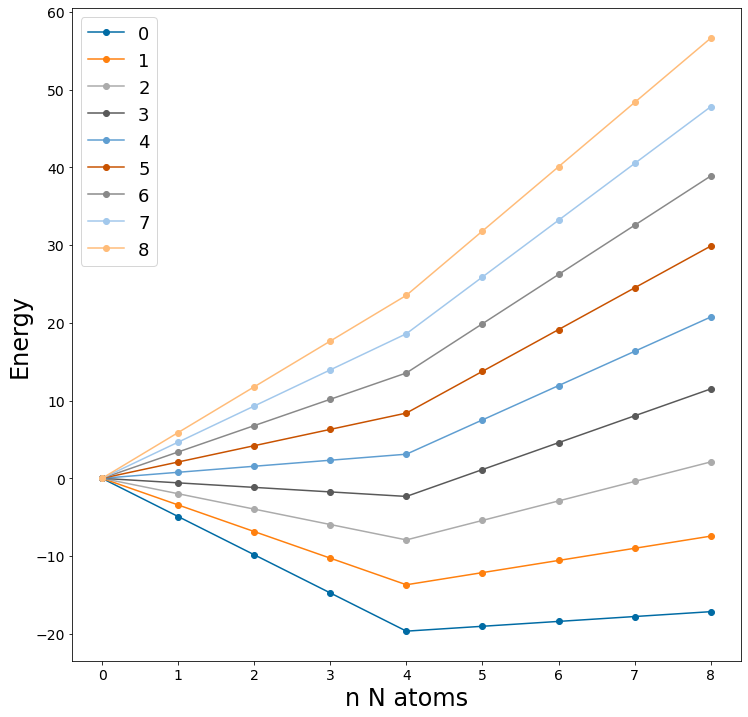

In [597]:
import matplotlib.pyplot as plt
num_sites = 8
fig, axs = plt.subplots(1,1,figsize=(12, 12), sharey=False)
x = range(0,num_sites+1)
for i,potential in enumerate(chemical_potential_all):
    y = energies_all[i]
    y = energies_min_all[i]
    print(np.argsort(y))
    #err = std_all[i]
    err = min_max_all[i]
    ##print(err)
    #axs.errorbar(x,y,yerr=err/2,fmt='-o',capsize=5,label=potential)
    axs.plot(x,y,'-o',label=potential)
axs.set_xlabel('n N atoms',fontsize=24)
axs.set_ylabel('Energy',fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.legend(fontsize=18)
fig.savefig('./data/chemical_potential/C_1_mu_all.jpg' ,dpi=200)